In [ ]:
# !pip install regina
# !pip install tqdm
# !pip install numba


In [19]:
import numpy as np
import sympy as sp
from tqdm import tqdm
from numba import njit
import multiprocessing as mp
mp.set_start_method('fork', force = True)
from matplotlib import pyplot as plt
import regina as rgn
from collections import defaultdict
import re


# code

In [20]:
@njit
def oppend(G,i):
    """
    :param G: Gauss diagram matrix
    :param i: a row index of G

    Output: another index of the same arrow
    """
    if i<0 or i >= G.shape[0]:
        print('index required has pass the range of G')
        raise ValueError("No valid index found for oppend.")


    for j in range(G.shape[0]):
        #if G[j,0] == G[i,0] and G[j,1] == -G[i,1]:
        if G[j,0] == G[i,0] and j != i:
            return j
    raise ValueError("No valid index found for oppend.") 
    
@njit
def getname(G):
    row_G = G.shape[0]
    name_list = np.zeros(row_G,dtype=np.int64)
    name_list[0] = G[0,0]
    if row_G == 1:
        return name_list[0:1]
    s = 1
    for i in range(1,row_G):
        if (G[i,0] in name_list[0:s]) == 0:#G[i,0] is new
            name_list[s] = G[i,0]
            s = s + 1
    return name_list[0:s]

@njit
def head_foot(G,n):
    A = np.zeros(2,dtype=np.int64)
    s = 0
    for i in range(0,G.shape[0]):
        if G[i,0]== n:
            A[s] = i
            s += 1
    B = A.copy()
    if G[A[0],1] == -1 and G[A[1],1] == 1:
        A[0] = B[1]
        A[1] = B[0]

    #   if G[i,1] == 1:
    #     A[0] = i
    #   else:
    #     A[1] = i
    if np.any(A) == 0:
        print('Sorry, I do not find the the labeled arrow')
    #else:
    return A
    
@njit
def index_names_trans(G):
    """
    param: G: Gauss matrix
    output: (name_list, ind_namelist_to_ind_matrix, ind_matrix_to_ind_namelist)
    ind_namelist_to_ind_matrix[ind_namelist]=[first ind in matrix, second ind in matrix]
    """
    numb_cr = G.shape[0]//2
    name_list = np.zeros(numb_cr,dtype = np.int64)
    ind_namelist_to_ind_matrix = np.zeros((numb_cr,2),dtype=np.int64)
    ind_matrix_to_ind_namelist = np.zeros(G.shape[0],dtype=np.int64)
    count_name = 0
    for i in range(G.shape[0]):
        appeared = False
        for j in range(0,count_name):
            if name_list[j] == G[i,0]: 
                appeared = True
                ind_matrix_to_ind_namelist[i] = j
                ind_namelist_to_ind_matrix[j,1] = i
                break
        if appeared == False:
            name_list[count_name] = G[i,0]
            ind_namelist_to_ind_matrix[count_name,0] = i
            ind_matrix_to_ind_namelist[i] = count_name
            count_name += 1
    return (name_list, ind_namelist_to_ind_matrix, ind_matrix_to_ind_namelist)

@njit
def normalize(G):
    """
    G: Gauss diagram
    return[G_normed,product of all (-1) in crossing of G]
    Remind: if a sign of arrow in G has 0, it does not matter.
    """
    N = G.copy()
    sign = 1
    name_list = np.zeros((G.shape[0]) // 2 ,dtype = np.int64)
    count_name = 0
    for i in range(G.shape[0]):
        appeared = False
        for j in range(count_name):
            if name_list[j] == G[i,0]:
                appeared = True
                N[i,0] = j + 1
                break 
        if appeared == False:
            name_list[count_name] = G[i,0]
            N[i,0] = count_name + 1
            if G[i,2] == -1: 
                sign = -sign
            count_name += 1 
    return (N, sign)


@njit
def examiner(G):
    """
    G: Guass diagram formula
    This function examins whethe G has errors.
    Output: True if no problems are found.
            False if some preblem has been found.
    """
    row_G = G.shape[0]
    col = G.shape[1]

    if row_G %2 != 0:
        print('Gauss diagram has odd number of rows')
        return False
    if col != 3:
        print('Gauss diagram should have 3 colomns')
        return False

    name_list = getname(G)
    N_names = name_list.shape[0]
    name_index = -np.ones((N_names,2),dtype=np.int64)
    name_count = np.zeros(N_names,dtype=np.int64)
    for i in range(row_G):
        for j in range(N_names):
            if G[i,0] == name_list[j]:
                name_index[j,name_count[j] %2] = i
                name_count[j] = name_count[j] + 1

    for i in range(N_names):
        if name_count[i] != 2:
            print('Gauss diagram matrix is wrong')
            return False
        if G[name_index[i,0],1] + G[name_index[i,1],1] != 0:
            print('Gauss diagram matrix is wrong')
            return False
        if G[name_index[i,0],2] != G[name_index[i,1],2]:
            print('Gauss diagram matrix is wrong')
            return False

    return True

@njit
def Gauss_to_band(G):
    """
    G: Gauss diagram
    Output: 
    """
    (G_name_list, G_ind_namelist_to_ind_matrix, G_ind_matrix_to_ind_namelist) = index_names_trans(G)
    oppend_G = np.zeros(G.shape[0],dtype=np.int64)
    len_name_list = len(G_name_list)
    oppend_G[G_ind_namelist_to_ind_matrix[:,0]] = G_ind_namelist_to_ind_matrix[:,1]
    oppend_G[G_ind_namelist_to_ind_matrix[:,1]] = G_ind_namelist_to_ind_matrix[:,0]
    crossings_check_list = np.zeros(len_name_list,dtype=np.int64)
    arc_direction = np.ones(G.shape[0]+1,dtype=np.int64)
    path = np.arange(G.shape[0]+1)# written for the arcs
    name_crossings = np.zeros(G.shape[0],dtype=np.int64)#using the namelist index to call crossings
    left_arcs_crossings = np.zeros((len_name_list,2),dtype=np.int64)#using the namelist index to call crossings
    right_arcs_crossings = np.zeros((len_name_list,2),dtype=np.int64)#using the namelist index to call crossings
    
    
    
    step = 0
    step_counter = 0
    while step != G.shape[0]:
        if arc_direction[step] == 1:#anti_clockwise on the arc
            name_crossings[step_counter] = G_ind_matrix_to_ind_namelist[step]
            if crossings_check_list[G_ind_matrix_to_ind_namelist[step]] == 0: #first time come to a crossing
                crossings_check_list[G_ind_matrix_to_ind_namelist[step]] = 1
                if arc_direction[oppend_G[step]]==1: #otherside is anticlockwise
                    left_arcs_crossings[G_ind_matrix_to_ind_namelist[step],:] = np.array([step,oppend_G[step]],dtype=np.int64)

                    index_begin_change_in_path = np.where(path==oppend_G[step])[0][0]
                    index_end_change_in_path = np.where(path==step+1)[0][0]
                    temp_min = np.min(np.array([index_begin_change_in_path,index_end_change_in_path]))
                    temp_max = np.max(np.array([index_begin_change_in_path,index_end_change_in_path]))
                    temp_path = path.copy()
                    for i in range(temp_min,temp_max+1):
                        arc_direction[path[i]] = -arc_direction[path[i]]
                        temp_path[i] = path[temp_min+temp_max-i]
                    path = temp_path
                    step = oppend_G[step]

                else: #otherside is clockwise
                    left_arcs_crossings[G_ind_matrix_to_ind_namelist[step],:] = np.array([step,1+oppend_G[step]],dtype=np.int64)

                    index_begin_change_in_path = np.where(path==oppend_G[step]+1)[0][0]
                    index_end_change_in_path = np.where(path==step+1)[0][0]
                    temp_min = np.min(np.array([index_begin_change_in_path,index_end_change_in_path]))
                    temp_max = np.max(np.array([index_begin_change_in_path,index_end_change_in_path]))
                    temp_path = path.copy()
                    for i in range(temp_min,temp_max+1):
                        arc_direction[path[i]] = -arc_direction[path[i]]
                        temp_path[i] = path[temp_min+temp_max-i]
                    path = temp_path
                    step = 1+oppend_G[step]
                    
            else: #second time to the crossing
                right_arcs_crossings[G_ind_matrix_to_ind_namelist[step],:] = np.array([step,path[1+step_counter]],dtype=np.int64)
                
                step = path[1+step_counter]
                
                
        else: #clockwise on the arc
            name_crossings[step_counter] = G_ind_matrix_to_ind_namelist[step-1]
            if crossings_check_list[G_ind_matrix_to_ind_namelist[step-1]] == 0: #first time come to a crossing
                crossings_check_list[G_ind_matrix_to_ind_namelist[step-1]] = 1
                if arc_direction[oppend_G[step-1]]==-1:#otherside is clockwise
                    left_arcs_crossings[G_ind_matrix_to_ind_namelist[step-1],:] = np.array([step,oppend_G[step-1]+1],dtype=np.int64)
                    
                    index_begin_change_in_path = np.where(path==oppend_G[step-1]+1)[0][0]
                    index_end_change_in_path = np.where(path==step-1)[0][0]
                    temp_min = np.min(np.array([index_begin_change_in_path,index_end_change_in_path]))
                    temp_max = np.max(np.array([index_begin_change_in_path,index_end_change_in_path]))
                    temp_path = path.copy()
                    for i in range(temp_min,temp_max+1):
                        arc_direction[path[i]] = -arc_direction[path[i]]
                        temp_path[i] = path[temp_min+temp_max-i]
                    path = temp_path
                    step = oppend_G[step-1]+1
                   
                else:#otherside is anticlockwise
                    left_arcs_crossings[G_ind_matrix_to_ind_namelist[step-1],:] = np.array([step,oppend_G[step-1]],dtype=np.int64)

                    index_begin_change_in_path = np.where(path==oppend_G[step-1])[0][0]
                    index_end_change_in_path = np.where(path==step-1)[0][0]
                    temp_min = np.min(np.array([index_begin_change_in_path,index_end_change_in_path]))
                    temp_max = np.max(np.array([index_begin_change_in_path,index_end_change_in_path]))
                    temp_path = path.copy()
                    for i in range(temp_min,temp_max+1):
                        arc_direction[path[i]] = -arc_direction[path[i]]
                        temp_path[i] = path[temp_min+temp_max-i]
                    path = temp_path
                    step = oppend_G[step-1]

            else: #second time to the crossing
                right_arcs_crossings[G_ind_matrix_to_ind_namelist[step-1],:] = np.array([step,path[1+step_counter]],dtype=np.int64)

                step = path[1+step_counter]

        step_counter += 1
    both_sides_crossings = np.zeros(len_name_list,dtype=np.int64)#using index of namelist_G
    for i in range(len_name_list):
        if (left_arcs_crossings[i,1]-left_arcs_crossings[i,0])*(right_arcs_crossings[i,1]-right_arcs_crossings[i,0])<0:
            both_sides_crossings[i] = 1
    
    
    ############
    ############the following part is for signed gauss diagram
    epsilon_crossings = np.ones(len_name_list,dtype=np.int64)
    above_down_crossings = np.zeros(len_name_list,dtype=np.int64)
    for i in range(len_name_list):
        len_left_arcs = len(left_arcs_crossings[i,:])
        len_right_arcs = len(right_arcs_crossings[i,:])
        len_total = len_left_arcs + len_right_arcs

        temp_arr = np.zeros(len_total, dtype = np.int64)
        temp_arr[0 : len_left_arcs] = left_arcs_crossings[i,:]
        temp_arr[len_left_arcs : len_total] = right_arcs_crossings[i,:]
        # temp_arr = np.append(left_arcs_crossings[i,:],right_arcs_crossings[i,:])
        # print('temp_arr=',temp_arr)
        temp_arr_sorted = sorted(temp_arr)


        if temp_arr[0] == temp_arr_sorted[2] and temp_arr[1] == temp_arr_sorted[0]:
            epsilon_crossings[i] = -1
        if temp_arr[0] == temp_arr_sorted[0] and temp_arr[1] == temp_arr_sorted[3]:
            epsilon_crossings[i] = -1
        if temp_arr[0] == temp_arr_sorted[3] and temp_arr[1] == temp_arr_sorted[1]:
            epsilon_crossings[i] = -1
        if temp_arr[0] == temp_arr_sorted[1] and temp_arr[1] == temp_arr_sorted[2]:
            epsilon_crossings[i] = -1
    
    for i in range(len_name_list):
        if G[G_ind_namelist_to_ind_matrix[i,0],1]*G[G_ind_namelist_to_ind_matrix[i,0],2]==epsilon_crossings[i]:
            above_down_crossings[i] = 1
        else:
            above_down_crossings[i] = -1 
    band_matrix = np.zeros((G.shape[0],4),dtype=np.int64)
    band_matrix[:,0] = name_crossings
    band_matrix[:,1] = both_sides_crossings[name_crossings]
    band_matrix[:,2] = above_down_crossings[name_crossings]
    band_matrix[:,3] = G[G_ind_namelist_to_ind_matrix[name_crossings,0],2]

    return band_matrix

@njit
def genus_zero_band(B):
    """
    B:band matrix
    """
    if np.any(B[:,1])==1:
        return False
    (B_name_list, B_ind_namelist_to_ind_matrix, B_ind_matrix_to_ind_namelist) = index_names_trans(B)
    len_B_name_list = len(B_name_list)
    above_index_namelist = np.array(
        [i for i in range(len_B_name_list) if  B[B_ind_namelist_to_ind_matrix[i,0],2] == 1 ]
    )
    below_index_namelist = np.array(
        [i for i in range(len_B_name_list) if B[B_ind_namelist_to_ind_matrix[i,0],2] == -1 ]
    )
    for i in range(len(above_index_namelist)-1):
        for j in range(i,len(above_index_namelist)):
            a = B_ind_namelist_to_ind_matrix[above_index_namelist[i],0]
            b = B_ind_namelist_to_ind_matrix[above_index_namelist[i],1]
            # [a,b] = B_ind_namelist_to_ind_matrix[above_index_namelist[i],:]
            c = B_ind_namelist_to_ind_matrix[above_index_namelist[j],0]
            d = B_ind_namelist_to_ind_matrix[above_index_namelist[j],1]
            # [c,d] = B_ind_namelist_to_ind_matrix[above_index_namelist[j],:]
            if (c-a)*(c-b)*(d-a)*(d-b)<0:
                return False
    for i in range(len(below_index_namelist)-1):
        for j in range(i,len(below_index_namelist)):
            a = B_ind_namelist_to_ind_matrix[below_index_namelist[i],0]
            b = B_ind_namelist_to_ind_matrix[below_index_namelist[i],1]
            # [a,b] = B_ind_namelist_to_ind_matrix[below_index_namelist[i],:]
            c = B_ind_namelist_to_ind_matrix[below_index_namelist[j],0]
            d = B_ind_namelist_to_ind_matrix[below_index_namelist[j],1]
            # [c,d] = B_ind_namelist_to_ind_matrix[below_index_namelist[j],:]
            if (c-a)*(c-b)*(d-a)*(d-b)<0:
                return False
    return True


def real_Gauss_signed(G):
    """
    G: Gauss diagram
    output: True if realisible. Otherwise False
    """
    B = Gauss_to_band(G)
    return genus_zero_band(B)

###################
#      REIDEMEISTER MOVE III

R3_table = np.zeros([2,3,3,32],int)
#The R3_table is in the following order:
#Global type: left(0-15)/right(16-31)
#local type: 1-8 (0-7 in index). Local type = up_int[(index+1)/2]
#It might be better to consider the ordering number in 16-base number system.

#################
################# Left types

##########
R3_table[:,:,0,0] = np.array([
    [1,-1,1],
    [2,-1,1]
],int)
R3_table[:,:,1,0] = np.array([
    [3,1,1],
    [1,1,1]
],int)
R3_table[:,:,2,0] = np.array([
    [3,-1,1],
    [2,1,1]
],int)

###########
R3_table[:,:,0,2] = np.array([
    [1,-1,-1],
    [2,-1,1]
],int)
R3_table[:,:,1,2] = np.array([
    [2,1,1],
    [3,1,-1]
],int)
R3_table[:,:,2,2] = np.array([
    [3,-1,-1],
    [1,1,-1]
],int)

###########
R3_table[:,:,0,4] = np.array([
    [1,-1,1],
    [2,-1,-1]
],int)
R3_table[:,:,1,4] = np.array([
    [3,1,-1],
    [2,1,-1]
],int)
R3_table[:,:,2,4] = np.array([
    [1,1,1],
    [3,-1,-1]
],int)

###########
R3_table[:,:,0,6] = np.array([
    [1,-1,-1],
    [2,-1,-1]
],int)
R3_table[:,:,1,6] = np.array([
    [1,1,-1],
    [3,1,1]
],int)
R3_table[:,:,2,6] = np.array([
    [2,1,-1],
    [3,-1,1]
],int)
####
####
for i in range(4):
    temp = np.zeros([6,3],int)

    temp[0,:] = R3_table[1,:,0,2*i]
    temp[1,:] = R3_table[0,:,0,2*i]

    temp[2,:] = R3_table[1,:,1,2*i]
    temp[3,:] = R3_table[0,:,1,2*i]

    temp[4,:] = R3_table[1,:,2,2*i]
    temp[5,:] = R3_table[0,:,2,2*i]

    temp = normalize(temp)[0]

    R3_table[:,:,0,2*i+1] = temp[0:2,:]
    R3_table[:,:,1,2*i+1] = temp[2:4,:]
    R3_table[:,:,2,2*i+1] = temp[4:6,:]
####
####
for i in range(2,6):#for case 6 and 7
    for j in range(3):
        R3_table[:,:,j,i+8] = R3_table[:,:,j,i]
        for k in range(2):
            R3_table[k,2,j,i+8] = -R3_table[k,2,j,i]

for i in range(0,2):#for case 8
    for j in range(3):
        R3_table[:,:,j,i+14] = R3_table[:,:,j,i]
        for k in range(2):
            R3_table[k,2,j,i+14] = -R3_table[k,2,j,i]

for i in range(6,8):#for case 5
    for j in range(3):
        R3_table[:,:,j,i+2] = R3_table[:,:,j,i]
        for k in range(2):
            R3_table[k,2,j,i+2] = -R3_table[k,2,j,i]

##########
##########
########## For the RIGHT types:

for i in range(0,8):
    temp0 = np.zeros([6,3],int)
    temp1 = np.zeros([6,3],int)


    temp0[0:2,:] = R3_table[:,:,0,2*i+1]
    temp0[2:4,:] = R3_table[:,:,2,2*i+1]
    temp0[4:6,:] = R3_table[:,:,1,2*i+1]

    temp0 = normalize(temp0)[0]

    temp1[0:2,:] = R3_table[:,:,0,2*i]
    temp1[2:4,:] = R3_table[:,:,2,2*i]
    temp1[4:6,:] = R3_table[:,:,1,2*i]

    temp1 = normalize(temp1)[0]

    R3_table[:,:,0,2*i+16] = temp0[0:2]
    R3_table[:,:,1,2*i+16] = temp0[2:4]
    R3_table[:,:,2,2*i+16] = temp0[4:6]

    R3_table[:,:,0,2*i+17] = temp1[0:2]
    R3_table[:,:,1,2*i+17] = temp1[2:4]
    R3_table[:,:,2,2*i+17] = temp1[4:6]

R3_table_matrix = np.zeros([6,3,32],int)
for i in range(32):
    R3_table_matrix[0:2,:,i] = R3_table[:,:,0,i]
    R3_table_matrix[2:4,:,i] = R3_table[:,:,1,i]
    R3_table_matrix[4:6,:,i] = R3_table[:,:,2,i]


R3_dhml = np.zeros([3,2,32],int)
#row_0: indice of d in order [head,foot]
#row_1: indice of hm
#row_2: indice of ml
for i in range(32):
    if i == 0 or i == 14:
        R3_dhml[:,:,i] = np.array([
            [3,0],
            [2,4],
            [5,1]
        ],int)
    elif i == 1 or i == 15:
        R3_dhml[:,:,i] = np.array([
            [2,1],
            [3,5],
            [4,0]
        ],int)

    elif i == 3 or i == 11:
        R3_dhml[:,:,i] = np.array([
            [3,0],
            [2,5],
            [4,1]
        ],int)
    elif i == 2 or i == 10:
        R3_dhml[:,:,i] = np.array([
            [2,1],
            [3,4],
            [5,0]
        ],int)

    elif i == 5 or i == 13:
        R3_dhml[:,:,i] = np.array([
            [2,0],
            [3,4],
            [5,1]
        ],int)
    elif i == 4 or i == 12:
        R3_dhml[:,:,i] = np.array([
            [3,1],
            [2,5],
            [4,0]
        ],int)

    elif i == 6 or i == 8:
        R3_dhml[:,:,i] = np.array([
            [2,0],
            [3,5],
            [4,1]
        ],int)
    elif i == 7 or i == 9:
        R3_dhml[:,:,i] = np.array([
            [3,1],
            [2,4],
            [5,0]
        ],int)

    elif i == 17 or i == 31:
        R3_dhml[:,:,i] = np.array([
            [5,0],
            [4,2],
            [3,1]
        ],int)
    elif i == 16 or i == 30:
        R3_dhml[:,:,i] = np.array([
            [4,1],
            [5,3],
            [2,0]
        ],int)

    elif i == 18 or i == 26:
        R3_dhml[:,:,i] = np.array([
            [5,0],
            [4,3],
            [2,1]
        ],int)
    elif i == 19 or i == 27:
        R3_dhml[:,:,i] = np.array([
            [4,1],
            [5,2],
            [3,0]
        ],int)

    elif i == 20 or i == 28:
        R3_dhml[:,:,i] = np.array([
            [4,0],
            [5,2],
            [3,1]
        ],int)
    elif i == 21 or i == 29:
        R3_dhml[:,:,i] = np.array([
            [5,1],
            [4,3],
            [2,0]
        ],int)

    elif i == 23 or i == 25:
        R3_dhml[:,:,i] = np.array([
            [4,0],
            [5,3],
            [2,1]
        ],int)
    elif i == 22 or i == 24:
        R3_dhml[:,:,i] = np.array([
            [5,1],
            [4,2],
            [3,0]
        ],int)
        
@njit
def R3(G,arr):
    """
    G:Gauss diagram matrix
    arr = [i,j,k] being numpy or list
    i:the first index of the two consecutive crossings in the first piece
    j:the first index of the two consecutive crossings in the second piece
    k:the first index of the two consecutive crossings in the third piece
    WARNING: i<j<k

    Outputs: [G_after_R3,R3_type_index, tracked index, dhml]
    """
    i = arr[0]
    j = arr[1]
    k = arr[2]
    row_G = G.shape[0]
    if i<j-1<k-2<row_G-3:
        row_G = row_G
    else:
        print('Index for R3 is not valide')
        return

    R3_ind = np.array([i,i+1,j,j+1,k,k+1],dtype=np.int64)

    ####examinator for R3 moves,8 possibilities
    extract = np.zeros((6,3),dtype=np.int64)
    temp_G = G[:,0:3]
    if G[i,1] == -1 and G[i+1,1] == -1:
        extract[0:2,:] = temp_G[i:i+2,:]
        extract[2:4,:] = temp_G[j:j+2,:]
        extract[4:6,:] = temp_G[k:k+2,:]
        rot = 0
    elif G[j,1] == -1 and G[j+1,1] == -1:
        extract[0:2,:] = temp_G[j:j+2,:]
        extract[2:4,:] = temp_G[k:k+2,:]
        extract[4:6,:] = temp_G[i:i+2,:]
        rot = 1
    elif G[k,1] == -1 and G[k+1,1] == -1:
        extract[0:2,:] = temp_G[k:k+2,:]
        extract[2:4,:] = temp_G[i:i+2,:]
        extract[4:6,:] = temp_G[j:j+2,:]
        rot = 2
    else:
        print('Index required cannot do R3 ----1')
        return
    #print('extract',extract)
    if examiner(extract) == False:
        print('Index required cannot do R3 ----2')
        return

    extract = normalize(extract)[0]
    #print('after normalization', extract)
    for s in range(32):
        #any addition; all multiplication
        if np.any(extract-R3_table_matrix[:,:,s]) == False: #addition result = 0
            R3_typeindex = s
            break
        else:
            if s == 31:
                print('Index required cannot do R3 ----3')
                return
    #print('R3_typeindex=',R3_typeindex)
    #print('rot=',rot)
    #print('d=',R3_dhml[0,:,R3_typeindex])
    #print('hm=',R3_dhml[1,:,R3_typeindex])
    #print('ml=',R3_dhml[2,:,R3_typeindex])
    dhml = np.zeros((3,2),dtype=np.int64)
    for a in range(3):
        for b in range(2):
            dhml[a,b] = R3_ind[(R3_dhml[a,b,R3_typeindex]+2*rot) % 6]
    if R3_typeindex % 2 ==0:
        R3_sign = 1
    else:
        R3_sign = -1
    #print('d=',dhml[0,:])
    #print('hm=',dhml[1,:])
    #print('ml=',dhml[2,:])
    ####examination finished

    #draw(G,'to be R3ed',np.array([i,i+1,j,j+1,k,k+1],int))
    ##########Contribution part(calculations)
   
    ################Deformation part
    G0 = G.copy()

    G0[i+1,:] = G[i,:]
    G0[i,:] = G[i+1,:]

    G0[j+1,:] = G[j,:]
    G0[j,:] = G[j+1,:]

    G0[k+1,:] = G[k,:]
    G0[k,:] = G[k+1,:]
    G0 = normalize(G0)[0]
    index_before_to_later = np.arange(0,row_G)

    index_before_to_later[i] = i+1
    index_before_to_later[i+1] = i
    index_before_to_later[j] = j+1
    index_before_to_later[j+1] = j
    index_before_to_later[k] = k+1
    index_before_to_later[k+1] = k
    #draw(G0,'after R3',np.array([index_before_to_later[i],index_before_to_later[i+1],index_before_to_later[j],index_before_to_later[j+1],index_before_to_later[k],index_before_to_later[k+1]],int))

    #dhml_new = np.zeros([3,2],int)
    #for a in range(3):
        #for b in range(2):
            #dhml_new[a,b] = index_before_to_later[dhml[a,b]]

    return (G0, R3_typeindex, index_before_to_later, dhml)

###################
#          DRAWINGS



@njit
def signstr(x):
    if x > 0:
        return '+'
    if x == 0:
        return ''
    if x < 0:
        return '--'


#sign position correction
@njit
def sp_correction(x):
    if x == 0:
        return 0#1
    else:
        return 0.16#1.15

@njit
def draw_prepare(Y):
    X = Y.copy()
    for i in range(0,int(X.shape[0])):
        if X[i,0]==0:
            X = X[0:i,:]
            break
    N = X.shape[0] // 2
    (name_list, ind_namelist_to_ind_matrix, ind_matrix_to_ind_namelist) = index_names_trans(X)
    head_foot_under_index_namelist = np.zeros((N,2),dtype=np.int64)
    for i in range(N):
        ind = ind_namelist_to_ind_matrix[i]
        if X[ind[0],1] == -1 and X[ind[1],1] == 1:
            head_foot_under_index_namelist[i] = np.array([ind[1],ind[0]],dtype=np.int64)
        elif X[ind[0],1] == 1 and X[ind[1],1] == -1:
            head_foot_under_index_namelist[i] = np.array([ind[0],ind[1]],dtype=np.int64)
        else:
            head_foot_under_index_namelist[i] = ind
    
    x = np.zeros(2*N)
    y = np.zeros(2*N)
    theta = np.zeros(2*N)
    for i in range(2*N):
        theta[i] = -np.pi/2+np.pi/(2*N)+i*np.pi/N
        x[i] = np.cos(theta[i])
        y[i] = np.sin(theta[i])
    return (head_foot_under_index_namelist,X,theta,x,y,N)



def draw(Y, tit='', color1_ind = np.array([],int), color2_ind = np.array([],int), color3_ind = np.array([],int)):
    """
    Y:the Gauss diagram matrix to be draw
    WARNING: We require that names in Y must be strictly positive.
    """
    a = 0.67
    b = 0.36
    
    ##a,b for drawing foot with string on the circle....
    
    (head_foot_under_index_namelist,X,theta,x,y,N) = draw_prepare(Y)


    plt.figure(figsize=(4,4))
    plt.xlim((-1.5,1.5))
    plt.ylim((-1.5,1.5))

    for i in range(N):
        ind_head = head_foot_under_index_namelist[i,0]
        ind_foot = head_foot_under_index_namelist[i,1]
        dx = -x[ind_head]+x[ind_foot]
        dy = -y[ind_head]+y[ind_foot]
        dr = np.sqrt(dx**2+dy**2)
        
        if X[ind_head,1] == 0 and X[ind_foot,1] == 0:
            if (ind_head in color1_ind) == 1 or (ind_foot in color1_ind) == 1:
                plt.annotate(signstr(X[ind_foot,2]),
                             xy=(x[ind_head],
                                 y[ind_head]),##arrow head coordinates
                             xytext =(x[ind_foot]+ (a+b*np.cos(theta[ind_foot]+3*np.pi/4)) *sp_correction(X[ind_foot,2])*(dx/dr),
                                      y[ind_foot]+ (a+b*np.cos(theta[ind_foot]+3*np.pi/4)) *sp_correction(X[ind_foot,2])*(dy/dr)),##arrow foot coordinates
                             arrowprops=dict(arrowstyle="-",
                                             color = "red",
                                             connectionstyle ="arc3")
                            )
            elif (ind_head in color2_ind) == 1 or (ind_foot in color2_ind) == 1:
                plt.annotate(signstr(X[ind_foot,2]),
                             xy=(x[ind_head],
                                 y[ind_head]),##arrow head coordinates
                             xytext =(x[ind_foot]+ (a+b*np.cos(theta[ind_foot]+3*np.pi/4)) *sp_correction(X[ind_foot,2])*(dx/dr),
                                      y[ind_foot]+ (a+b*np.cos(theta[ind_foot]+3*np.pi/4)) *sp_correction(X[ind_foot,2])*(dy/dr)),##arrow foot coordinates
                             arrowprops=dict(arrowstyle="-",
                                             color = "orange",
                                             connectionstyle ="arc3")
                            )
            elif (ind_head in color3_ind) == 1 or (ind_foot in color3_ind) == 1:
                plt.annotate(signstr(X[ind_foot,2]),
                             xy=(x[ind_head],
                                 y[ind_head]),##arrow head coordinates
                             xytext =(x[ind_foot]+ (a+b*np.cos(theta[ind_foot]+3*np.pi/4)) *sp_correction(X[ind_foot,2])*(dx/dr),
                                      y[ind_foot]+ (a+b*np.cos(theta[ind_foot]+3*np.pi/4)) *sp_correction(X[ind_foot,2])*(dy/dr)),##arrow foot coordinates
                             arrowprops=dict(arrowstyle="-",
                                             color = "blue",
                                             connectionstyle ="arc3")
                            )
            else: 
                plt.annotate(signstr(X[ind_foot,2]),
                             xy=(x[ind_head],
                                 y[ind_head]),##arrow head coordinates
                             xytext =(x[ind_foot]+ (a+b*np.cos(theta[ind_foot]+3*np.pi/4)) *sp_correction(X[ind_foot,2])*(dx/dr),
                                      y[ind_foot]+ (a+b*np.cos(theta[ind_foot]+3*np.pi/4)) *sp_correction(X[ind_foot,2])*(dy/dr)),##arrow foot coordinates
                             arrowprops=dict(arrowstyle="-",
                                             connectionstyle ="arc3")
                            )
            
        elif X[ind_head,1] == 1 and X[ind_foot,1] == -1:
            if (ind_head in color1_ind) == 1 or (ind_foot in color1_ind) == 1:
                plt.annotate(signstr(X[ind_foot,2]),
                             xy=(x[ind_head],
                                 y[ind_head]),##arrow head coordinates
                             xytext =(x[ind_foot]+ (a+b*np.cos(theta[ind_foot]+3*np.pi/4)) *sp_correction(X[ind_foot,2])*(dx/dr),
                                      y[ind_foot]+ (a+b*np.cos(theta[ind_foot]+3*np.pi/4)) *sp_correction(X[ind_foot,2])*(dy/dr)),##arrow foot coordinates
                             arrowprops=dict(arrowstyle="-|>",
                                             color = "red",
                                             connectionstyle ="arc3,rad=0")
                            )

            elif (ind_head in color2_ind) == 1 or (ind_foot in color2_ind) == 1:
                plt.annotate(signstr(X[ind_foot,2]),
                             xy=(x[ind_head],
                                 y[ind_head]),##arrow head coordinates
                             xytext =(x[ind_foot]+ (a+b*np.cos(theta[ind_foot]+3*np.pi/4)) *sp_correction(X[ind_foot,2])*(dx/dr),
                                      y[ind_foot]+ (a+b*np.cos(theta[ind_foot]+3*np.pi/4)) *sp_correction(X[ind_foot,2])*(dy/dr)),##arrow foot coordinates
                             arrowprops=dict(arrowstyle="-|>",
                                             color = "orange",
                                             connectionstyle ="arc3,rad=0")
                            )
            elif (ind_head in color3_ind) == 1 or (ind_foot in color3_ind) == 1:
                plt.annotate(signstr(X[ind_foot,2]),
                             xy=(x[ind_head],
                                 y[ind_head]),##arrow head coordinates
                             xytext =(x[ind_foot]+ (a+b*np.cos(theta[ind_foot]+3*np.pi/4)) *sp_correction(X[ind_foot,2])*(dx/dr),
                                      y[ind_foot]+ (a+b*np.cos(theta[ind_foot]+3*np.pi/4)) *sp_correction(X[ind_foot,2])*(dy/dr)),##arrow foot coordinates
                             arrowprops=dict(arrowstyle="-|>",
                                             color = "blue",
                                             connectionstyle ="arc3,rad=0")
                            )
            else: 
                plt.annotate(signstr(X[ind_foot,2]),
                             xy=(x[ind_head],
                                 y[ind_head]),##arrow head coordinates
                             xytext =(x[ind_foot]+ (a+b*np.cos(theta[ind_foot]+3*np.pi/4)) *sp_correction(X[ind_foot,2])*(dx/dr),
                                      y[ind_foot]+ (a+b*np.cos(theta[ind_foot]+3*np.pi/4)) *sp_correction(X[ind_foot,2])*(dy/dr)),##arrow foot coordinates
                             arrowprops=dict(arrowstyle="-|>",
                                             connectionstyle ="arc3,rad=0")
                            )
            

    circle = plt.Circle((0,0),radius = 1,color = 'black', fill=False)
    plt.gcf().gca().add_artist(circle)
    plt.plot(0,-1,'o',color = 'b')#basepoint
    plt.title(tit)
    plt.show()
    return


##################

# cabled_knot(data_knots[0].Gauss_matrix, 2, np.array([[1,1]],int))
@njit
def cable_to_parallel_string(G, n, exam = False):
    """
    param: G: Gauss matrix of a KNOT
    param: n: to be n parallel-cabled
    output: nG
    
    nG: Gauss matrix of n-parallel-cabled G. 4 columns [name, head/foot/, sign, component]
    component is named by natural numbers. Component part is a increassing sequence along the row, for example: 0,0,1,1,1,2
    """
    if exam == True:
        examiner(G)
    nG = np.zeros((n ** 2 * G.shape[0],4),dtype = np.int64)
    for p in range(n):
        nG[p * G.shape[0] * n : (p + 1) * G.shape[0] * n, 3] = p
    
    for i in range(G.shape[0]):
#         nG[i * n ** 2 : i * (n+1) ** 2, 1] = G[i,1]
#         nG[i * n ** 2 : i * (n+1) ** 2, 2] = G[i,2]
        
        if G[i, 1] == 1 and G[i, 2] == 1:
            for cpn in range(n):# on which component
                ind_start_cpn = cpn * G.shape[0] * n
                nG[ind_start_cpn + i * n : ind_start_cpn +(i + 1) * n, 1] = G[i, 1]
                nG[ind_start_cpn + i * n : ind_start_cpn +(i + 1) * n, 2] = G[i, 2]
                for s in range(n): 
                    nG[ind_start_cpn + i * n + s,0] = G[i, 0] * n ** 2 + cpn * n + (n - 1 - s)
        
        if G[i, 1] == -1 and G[i, 2] == 1:
            for cpn in range(n):# on which component
                ind_start_cpn = cpn * G.shape[0] * n
                nG[ind_start_cpn + i * n : ind_start_cpn +(i + 1) * n, 1] = G[i, 1]
                nG[ind_start_cpn + i * n : ind_start_cpn +(i + 1) * n, 2] = G[i, 2]
                for s in range(n): 
                    nG[ind_start_cpn + i * n + s,0] = G[i, 0] * n ** 2 + s * n + cpn
        
        if G[i, 1] == 1 and G[i, 2] == -1:
            for cpn in range(n):# on which component
                ind_start_cpn = cpn * G.shape[0] * n
                nG[ind_start_cpn + i * n : ind_start_cpn +(i + 1) * n, 1] = G[i, 1]
                nG[ind_start_cpn + i * n : ind_start_cpn +(i + 1) * n, 2] = G[i, 2]
                for s in range(n): 
                    nG[ind_start_cpn + i * n + s,0] = G[i, 0] * n ** 2 + cpn * n + s
                    
        if G[i, 1] == -1 and G[i, 2] == -1:
            for cpn in range(n):# on which component
                ind_start_cpn = cpn * G.shape[0] * n
                nG[ind_start_cpn + i * n : ind_start_cpn +(i + 1) * n, 1] = G[i, 1]
                nG[ind_start_cpn + i * n : ind_start_cpn +(i + 1) * n, 2] = G[i, 2]
                for s in range(n): 
                    nG[ind_start_cpn + i * n + s,0] = G[i, 0] * n ** 2 + (n - 1 - s) * n + cpn
        
    return nG

#Remark: cpn = index_new // (G.shape[0] * n) which also == nG[i,3]
# index_old = (index_new % (G.shape[0] * n)) // n
# name_old = nG[index_new,0] // n ** 2
# index_new_array_on_strand_k = np.arange(k * G.shape[0] * n + index_old * n , k * G.shape[0] * n + (index_old + 1) * n)


@njit
def close_string(string_matrix, braid = np.zeros((1,1),dtype = np.int64)):
    """
    param: braid: 2d-array. Assume to be a permutation of all strands except for the trivial braid
    param: string_matrix: a 4 columns matrix [names, head/foot, sign, component]
    
    output: (closed_string, index_string_old_to_new, strand_index_bounds)
    """
    numb_strands = string_matrix[-1,3]+1
    
    if numb_strands < np.max(braid[:,0])+1:
        print('cannot add the braid to a string link with less strands than the braid')
        return None
#     strand_index_bounds = np.zeros((numb_strands,2), dtype = np.int64)

    strand_index = np.zeros(numb_strands+1, dtype = np.int64)
    strand_index[-1] = string_matrix.shape[0]
    count = 1
    for i in range(string_matrix.shape[0]-1):
        if string_matrix[i+1,3] > string_matrix[i,3]: 
            strand_index[count] = i+1
            count += 1

    if np.any(braid) == 0: # trivial braid
        index_string_old_to_new = np.arange(string_matrix.shape[0])
#         for i in range(numb_strands):
#             strand_index_bounds[i,:] = np.array([strand_index[i],strand_index[i+1]])
        perm_inv = np.arange(numb_strands)
        return (string_matrix[:,0:4], index_string_old_to_new, perm_inv)
    # treat braid

    mat_perm= np.zeros((braid.shape[0]+1,numb_strands),dtype = np.int64)
    mat_perm[0,:] = np.arange(0,numb_strands)
    crossings_braid = np.zeros((numb_strands,braid.shape[0],3),dtype = np.int64)
    steps = np.zeros(numb_strands,dtype = np.int64)
    for i in range(braid.shape[0]):
#         print('i=',i,'braid[i,0]=',braid[i,0])
        mat_perm[i+1,:] = mat_perm[i,:]
        if braid[i,0] > 0: # works for trivial braid
            mat_perm[i+1,braid[i,0]-1] = mat_perm[i,braid[i,0]]
            mat_perm[i+1,braid[i,0]] = mat_perm[i,braid[i,0]-1]
            if braid[i,1] == 1:
                head_strand = mat_perm[i,braid[i,0]]
                foot_strand = mat_perm[i,braid[i,0]-1]
                crossings_braid[head_strand,steps[head_strand],:] = np.array([i+1,1,1],dtype = np.int64)
                crossings_braid[foot_strand,steps[foot_strand],:] = np.array([i+1,-1,1],dtype = np.int64)
                steps[head_strand] += 1
                steps[foot_strand] += 1
            elif braid[i,1] == -1:
                head_strand = mat_perm[i,braid[i,0]-1]
                foot_strand = mat_perm[i,braid[i,0]]
                crossings_braid[head_strand,steps[head_strand],:] = np.array([i+1,1,-1],dtype = np.int64)
                crossings_braid[foot_strand,steps[foot_strand],:] = np.array([i+1,-1,-1],dtype = np.int64)
                steps[head_strand] += 1
                steps[foot_strand] += 1
    perm_inv = np.argsort(mat_perm[-1,:])
    crossings_braid[:,:,0] += np.max(string_matrix[:,0])
    
    closed_string = np.zeros((string_matrix.shape[0] + braid.shape[0] * 2, 4), dtype = np.int64)
    
    index_string_old_to_new = np.zeros(string_matrix.shape[0], dtype = np.int64)

    step_row = 0 
    strand_piece = 0
    step_index_old_to_new = 0
    for i in range(0, numb_strands):
#         print('i=',i)
        ## string_matrix piece copy 
        
        step_middle = step_row + strand_index[strand_piece+1] - strand_index[strand_piece]
        closed_string[step_row : step_middle, 0:3] = string_matrix[
            strand_index[strand_piece] : strand_index[strand_piece + 1],
            0:3
        ]
        closed_string[step_row : step_middle, 3] = i 
#         strand_index_bounds[i,:] = np.array([step_row, step_middle])

        index_string_old_to_new[strand_index[strand_piece] : strand_index[strand_piece+1]] = np.arange(step_row,step_middle)
        ##braid part copy
    
        step_row = step_middle + steps[strand_piece]
        closed_string[step_middle : step_row, 0:3] = crossings_braid[strand_piece, 0 : steps[strand_piece], :]
        closed_string[step_middle : step_row, 3] = -i-1

        strand_piece = perm_inv[strand_piece]
    
    return (closed_string, index_string_old_to_new, perm_inv)

@njit
def cabled_knot(G, n, braid = np.zeros((1,1),dtype = np.int64) ):
    
    nG = cable_to_parallel_string(G, n, exam = False)
    # cpn = index_new // (G.shape[0] * n) which also == nG[i,3]
    # index_old = (index_new % (G.shape[0] * n)) // n
    # name_old = nG[index_new,0] // n ** 2
    # index_new_array_on_strand_k = np.arange(k * G.shape[0] * n + index_old * n , k * G.shape[0] * n + (index_old + 1) * n)
    old_to_new_index_arr = np.zeros((G.shape[0], n, n),dtype = np.int64)
    for i in range(G.shape[0]): # index i in G
        for k in range(n):# on strand k
            old_to_new_index_arr[i,k,:] = np.arange(k * G.shape[0] * n + i * n , k * G.shape[0] * n + (i + 1) * n)
    (closed_string, index_string_old_to_new, perm_inv) = close_string(nG, braid)
    for i in range(G.shape[0]): # index i in G
        strand = 0
        for k in range(n):# on strand k
            old_to_new_index_arr[i,k,:] = index_string_old_to_new[old_to_new_index_arr[i,k,:]]
#             strand = perm_inv[strand]
    return (closed_string, old_to_new_index_arr)



def find_connected_components_with_mapping(adj_list):
    def dfs(node, visited, component, comp_id):
        visited.add(node)
        component.append(node)
        node_to_component[node] = comp_id  # 在 DFS 中同步标记分量编号
        for neighbor in adj_list[node]:
            if neighbor not in visited:
                dfs(neighbor, visited, component, comp_id)

    visited = set()
    components = []
    node_to_component = {}

    for node in adj_list:
        if node not in visited:
            component = []
            comp_id = len(components)  # 当前分量编号
            dfs(node, visited, component, comp_id)
            components.append(component)

    return components, node_to_component

def get_PD_parallel_2cabled_cr_smoothed(G_in, smoothed_cr_in):
    # determing it is of parallel type of crossed type
    if real_Gauss_signed(G_in[:, 0 : 3]):
        # crossed type
        # print('crossed type')
        G = G_in[:, 0 : 3]
        smoothed_cr = smoothed_cr_in
    else:
        # parallel type, need to add an auxiliary arrow
        # print('parallel type')
        G = np.zeros((G_in.shape[0] + 2, 3), int)
        arc_infty = 0
        if G_in[0, 3] == 1:
            arc_infty = 0
        elif G_in[G_in.shape[0] - 1, 3] == 0:
            arc_infty = G_in.shape[0]
        else:
            for i in range(1, G_in.shape[0]):
                if (G_in[i, 3] - G_in[i - 1, 3] >= 1):
                    arc_infty = i
        name_max = np.max(G_in[:, 0])
        G[0] = [name_max + 1, -1, -1]
        G[1 : 1 + arc_infty] = G_in[0 : arc_infty, 0 : 3]
        G[1 + arc_infty] = [name_max + 1, 1, -1]
        G[2 + arc_infty : 2 + G_in.shape[0]] = G_in[arc_infty : G_in.shape[0], 0 : 3]
        smoothed_cr = np.zeros(len(smoothed_cr_in) + 1, dtype = np.int64)
        smoothed_cr[1 : smoothed_cr.shape[0]] = smoothed_cr_in + 1
    # print('smoothed_cr = ', smoothed_cr)
    
    # print(real_Gauss_signed(G))
    # draw(G,'G')
    # print(Gauss_matrix_to_PD(G) - 1)
    (name_list, ind_namelist_to_ind_matrix, ind_matrix_to_ind_namelist) = index_names_trans(np.ascontiguousarray(G))
    # give arcs new names

    # 构建邻接表
    adj_list = defaultdict(list)
    for i in range(G.shape[0] + 1):
        adj_list[i].append(i)
    adj_list[G.shape[0]].append(0)
    adj_list[0].append(G.shape[0])
    for sm_cr in smoothed_cr:
        adj_list[ind_namelist_to_ind_matrix[sm_cr, 0]].append(ind_namelist_to_ind_matrix[sm_cr, 1] + 1)
        adj_list[ind_namelist_to_ind_matrix[sm_cr, 0] + 1].append(ind_namelist_to_ind_matrix[sm_cr, 1])
        
        adj_list[ind_namelist_to_ind_matrix[sm_cr, 1] + 1].append(ind_namelist_to_ind_matrix[sm_cr, 0])
        adj_list[ind_namelist_to_ind_matrix[sm_cr, 1]].append(ind_namelist_to_ind_matrix[sm_cr, 0] + 1)
        # ind_namelist_to_ind_matrix[sm_cr]
    # print('adj_list = ', adj_list)
    (new_arcs, old_arc_to_new) = find_connected_components_with_mapping(adj_list)
    # print('old_arc_to_new =', old_arc_to_new)
    # print('new_arcs = ', new_arcs)
    appearance_new_arcs = np.zeros(len(new_arcs), int)
    numb_cr = G.shape[0] // 2 - len(smoothed_cr)
    cr_list_mask = np.ones(G.shape[0] // 2, int)
    cr_list_mask[smoothed_cr] = 0
    cr_list = np.zeros(numb_cr, int)
    count_cr = 0
    for i in range(G.shape[0] // 2):
        if cr_list_mask[i]:
            cr_list[count_cr] = i
            count_cr += 1
    # print('cr_list = ', cr_list)
    # print('ind_namelist_to_ind_matrix', ind_namelist_to_ind_matrix)
    PD = np.zeros((numb_cr, 4), dtype = np.int64)
    for i in range(numb_cr):
        # print('i = ', i)
        cr = cr_list[i]
        if G[ind_namelist_to_ind_matrix[cr, 0], 2] == 1:# positive 
            # print('positive')
            if G[ind_namelist_to_ind_matrix[cr, 0], 1] == 1: # first head
                # print('ind_namelist_to_ind_matrix[cr]=', ind_namelist_to_ind_matrix[cr])
                PD[i, :] = [
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 1]], 
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 0] + 1],
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 1] + 1], 
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 0]]
                ]
            else: # first foot
                PD[i, :] = [
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 0]], 
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 1] + 1],
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 0] + 1], 
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 1]]
                ]
        else: # negative
            # print('negative')
            if G[ind_namelist_to_ind_matrix[cr, 0], 1] == 1: # first head
                # print('first head')
                PD[i, :] = [
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 1]], 
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 0]],
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 1] + 1], 
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 0] + 1]
                ]
            else: # first foot
                # print('first foot')
                PD[i, :] = [
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 0]], 
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 1]],
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 0] + 1], 
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 1] + 1]
                ]
    
    for i in range(numb_cr):
        for j in range(4):
            appearance_new_arcs[PD[i, j]] = 1
    # print()
    numb_extra_components = -np.sum(appearance_new_arcs - 1)
    
    # PD %= G.shape[0] 
    PD += 1 
    # print(PD)
    return (PD, numb_extra_components)

def get_PD_crossed_2cabled_cr_smoothed(G_in, smoothed_cr_in):
    """ 
    add a negative crossing 
    """
    arc_infty = 0
    if G_in[0, 3] == 1:
        arc_infty = 0
    elif G_in[G_in.shape[0] - 1, 3] == 0:
        arc_infty = G_in.shape[0]
    else:
        for i in range(1, G_in.shape[0]):
            if (G_in[i, 3] - G_in[i - 1, 3] >= 1):
                arc_infty = i
    # print('G_in = ', G_in)
    # print('arc_infty = ', arc_infty)
    name_max = np.max(G_in[:, 0])
    # determing it is of parallel type of crossed type
    if real_Gauss_signed(G_in[:, 0 : 3]):
        # crossed type,
        # need to add an auxiliary arrow
        # print('crossed type')
        G = np.zeros((G_in.shape[0] + 4, 3), int)
        G[0] = [name_max + 1, 1, -1] # to be smoothed, sign not matter
        G[1] = [name_max + 2, -1, -1]
        G[2 : 2 + arc_infty] = G_in[0 : arc_infty, 0 : 3]
        G[2 + arc_infty] = [name_max + 1, -1, -1]
        G[3 + arc_infty] = [name_max + 2, 1, -1]
        G[4 + arc_infty : 4 + G_in.shape[0]] = G_in[arc_infty : G_in.shape[0], 0 : 3]
        smoothed_cr = np.zeros(len(smoothed_cr_in) + 1, dtype = np.int64)
        smoothed_cr[1 : smoothed_cr.shape[0]] = smoothed_cr_in + 2
    else:
        # parallel type
        # print('parallel type')
        G = np.zeros((G_in.shape[0] + 2, 3), int)
        G[0] = [name_max + 1, -1, -1]
        G[1 : 1 + arc_infty] = G_in[0 : arc_infty, 0 : 3]
        G[1 + arc_infty] = [name_max + 1, 1, -1]
        G[2 + arc_infty : 2 + G_in.shape[0]] = G_in[arc_infty : G_in.shape[0], 0 : 3]
        smoothed_cr = smoothed_cr_in + 1
    # print('smoothed_cr = ', smoothed_cr)
    # print(real_Gauss_signed(G))
    # draw(G,'G')
    # print(Gauss_matrix_to_PD(G) - 1)
    (name_list, ind_namelist_to_ind_matrix, ind_matrix_to_ind_namelist) = index_names_trans(np.ascontiguousarray(G))
    # give arcs new names

    # 构建邻接表
    adj_list = defaultdict(list)
    for i in range(G.shape[0] + 1):
        adj_list[i].append(i)
    adj_list[G.shape[0]].append(0)
    adj_list[0].append(G.shape[0])
    for sm_cr in smoothed_cr:
        adj_list[ind_namelist_to_ind_matrix[sm_cr, 0]].append(ind_namelist_to_ind_matrix[sm_cr, 1] + 1)
        adj_list[ind_namelist_to_ind_matrix[sm_cr, 0] + 1].append(ind_namelist_to_ind_matrix[sm_cr, 1])
        
        adj_list[ind_namelist_to_ind_matrix[sm_cr, 1] + 1].append(ind_namelist_to_ind_matrix[sm_cr, 0])
        adj_list[ind_namelist_to_ind_matrix[sm_cr, 1]].append(ind_namelist_to_ind_matrix[sm_cr, 0] + 1)
        # ind_namelist_to_ind_matrix[sm_cr]
    # print('adj_list = ', adj_list)
    (new_arcs, old_arc_to_new) = find_connected_components_with_mapping(adj_list)
    # print('old_arc_to_new =', old_arc_to_new)
    # print('new_arcs = ', new_arcs)
    appearance_new_arcs = np.zeros(len(new_arcs), int)
    numb_cr = G.shape[0] // 2 - len(smoothed_cr)
    cr_list_mask = np.ones(G.shape[0] // 2, int)
    cr_list_mask[smoothed_cr] = 0
    cr_list = np.zeros(numb_cr, int)
    count_cr = 0
    for i in range(G.shape[0] // 2):
        if cr_list_mask[i]:
            cr_list[count_cr] = i
            count_cr += 1
    # print('cr_list = ', cr_list)
    # print('ind_namelist_to_ind_matrix', ind_namelist_to_ind_matrix)
    PD = np.zeros((numb_cr, 4), dtype = np.int64)
    for i in range(numb_cr):
        # print('i = ', i)
        cr = cr_list[i]
        if G[ind_namelist_to_ind_matrix[cr, 0], 2] == 1:# positive 
            # print('positive')
            if G[ind_namelist_to_ind_matrix[cr, 0], 1] == 1: # first head
                # print('ind_namelist_to_ind_matrix[cr]=', ind_namelist_to_ind_matrix[cr])
                PD[i, :] = [
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 1]], 
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 0] + 1],
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 1] + 1], 
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 0]]
                ]
            else: # first foot
                PD[i, :] = [
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 0]], 
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 1] + 1],
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 0] + 1], 
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 1]]
                ]
        else: # negative
            # print('negative')
            if G[ind_namelist_to_ind_matrix[cr, 0], 1] == 1: # first head
                # print('first head')
                PD[i, :] = [
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 1]], 
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 0]],
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 1] + 1], 
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 0] + 1]
                ]
            else: # first foot
                # print('first foot')
                PD[i, :] = [
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 0]], 
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 1]],
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 0] + 1], 
                    old_arc_to_new[ind_namelist_to_ind_matrix[cr, 1] + 1]
                ]
    
    for i in range(numb_cr):
        for j in range(4):
            appearance_new_arcs[PD[i, j]] = 1
    
    numb_extra_components = -np.sum(appearance_new_arcs - 1)
    
    # PD %= G.shape[0] 
    PD += 1 
    # print(PD)
    return (PD, numb_extra_components)

def normalize_pd(pd_code):
    """
    将任意 PD code 的弧编号重新映射到 1..2n 的连续整数。
    :param pd_code: List[List[int]]，PD code
    :return: normalized_pd, mapping
    """
    # 获取所有出现过的弧编号
    all_strands = sorted(set(x for quad in pd_code for x in quad))
    
    # 建立映射：旧编号 -> 新编号
    mapping = {old: new for new, old in enumerate(all_strands, start=1)}
    
    # 应用映射
    normalized_pd = [[mapping[x] for x in quad] for quad in pd_code]
    
    return normalized_pd, mapping

def homfly_pd(pd):
    """ 
    from an 2d arr pdcode to a sympy expression of the homfly poly.
    """
    pd_code = pd.tolist()
    # print(repr(pd_code))
    # L = rgn.Link.fromPD(pd_code)

    pd_code_normed = normalize_pd(pd_code)[0]
    L = rgn.Link.fromPD(pd_code_normed)

    poly_az = L.homfly()
    poly_str = poly_az.str('A', 'Z')

    # 1. 将 ^ 替换成 Python 幂运算 **
    poly_str = poly_str.replace('^', '**')

    # 2. 数字和变量之间插入 * (如 14 A -> 14*A)
    poly_str = re.sub(r'(\d)\s+([A-Z])', r'\1*\2', poly_str)

    # 3. 变量与变量之间插入 * (如 A Z -> A*Z)
    poly_str = re.sub(r'([A-Z])\s+([A-Z])', r'\1*\2', poly_str)

    # 4. 带指数的变量之间插入 * (如 A**10 Z**2 -> A**10*Z**2)
    poly_str = re.sub(r'([A-Z]\*\*\d+)\s+([A-Z])', r'\1*\2', poly_str)

    # 5. 修复 "+ -" 变成 "-"
    poly_str = re.sub(r'\+\s*-', '-', poly_str)

    A, Z = sp.symbols('A Z')
    # print(poly_str)
    sympy_expr = sp.sympify(poly_str)
    # print(sympy_expr)
    return sympy_expr

def homflypt_2cabled_cr_smoothed(G, smoothed_cr, multi_threads = False):
    (name_list, ind_namelist_to_ind_matrix, ind_matrix_to_ind_namelist) = index_names_trans(np.ascontiguousarray(G))
    writhe_smoothed = writhe(G) - np.sum(G[ind_namelist_to_ind_matrix[smoothed_cr, 0], 2])
    A, Z = sp.symbols('A Z')
    (pd_parallel, extra_compo_parallel) = get_PD_parallel_2cabled_cr_smoothed(G, smoothed_cr)
    # print('pd_parallel = ')
    # print(pd_parallel)
    # print('extra_compo_parallel = ', extra_compo_parallel)
    poly_parallel = homfly_pd(pd_parallel)
    poly_parallel *= ((A - A**(-1))/Z)**extra_compo_parallel

    (pd_crossed, extra_compo_crossed)  = get_PD_crossed_2cabled_cr_smoothed(G, smoothed_cr)
    # print('pd_crossed = ')
    # print(pd_crossed)
    # print('extra_compo_crossed = ', extra_compo_crossed)
    poly_crossed = homfly_pd(pd_crossed)
    poly_crossed *= ((A - A**(-1))/Z)**extra_compo_crossed

    
    # print('poly_parallel = ', poly_parallel)
    # print('poly_crossed = ', poly_crossed)
    det = 1 - ((A - A**(-1))/Z)**2
    
    poly_sig = poly_parallel - (A - A**(-1))/Z * poly_crossed
    poly_id = - (A - A**(-1))/Z * poly_parallel + poly_crossed

    poly_sig = sp.simplify(poly_sig / det * A**(writhe_smoothed - 1))
    poly_id = sp.simplify(poly_id / det * A**writhe_smoothed )

    return (poly_sig, poly_id)

def R3_contri_2cabled_type2(G, R3_idx, multi_threads = False):
    (G_after_R3, R3_typeindex, index_before_to_later, dhml) = R3(G, R3_idx)

    (name_list_G, ind_namelist_to_ind_matrix_G, ind_matrix_to_ind_namelist_G) = index_names_trans(np.ascontiguousarray(G))
    cr_d = ind_matrix_to_ind_namelist_G[dhml[0, 0]]
    cr_hm = ind_matrix_to_ind_namelist_G[dhml[1, 0]]
    cr_ml = ind_matrix_to_ind_namelist_G[dhml[2, 0]]
    
    sign = 1
    # type 1
    if R3_typeindex == 1 or R3_typeindex == 16:
        # print('type1 pos')
        smoothed_cr = np.array([cr_ml], int)
    elif R3_typeindex == 0 or R3_typeindex == 17:
        # print('type1 neg')
        sign = -1
        smoothed_cr = np.array([cr_ml], int)
    # type 8
    elif R3_typeindex == 15 or R3_typeindex == 30:
        # print('type8 pos')
        smoothed_cr = np.array([cr_ml], int)
    elif R3_typeindex == 14 or R3_typeindex == 31:
        # print('type8 neg')
        sign = -1
        smoothed_cr = np.array([cr_ml], int)
    # type 3
    elif R3_typeindex == 7 or R3_typeindex == 22:
        # print('type3 pos')
        smoothed_cr = np.array([cr_ml, cr_d, cr_hm], int)
    elif R3_typeindex == 6 or R3_typeindex == 23:
        # print('type3 neg') 
        sign = -1
        smoothed_cr = np.array([cr_ml, cr_d, cr_hm], int)
    # type 7
    elif R3_typeindex == 9 or R3_typeindex == 24:
        # print('type7 pos')
        smoothed_cr = np.array([cr_ml, cr_d, cr_hm], int)
    elif R3_typeindex == 8 or R3_typeindex == 25:
        # print('type7 neg')
        sign = -1
        smoothed_cr = np.array([cr_ml, cr_d, cr_hm], int)
    # type 4
    elif R3_typeindex == 5 or R3_typeindex == 20:
        # print('type4 pos')
        smoothed_cr = np.array([cr_ml], int)
    elif R3_typeindex == 4 or R3_typeindex == 21:
        # print('type4 neg')
        sign = -1
        smoothed_cr = np.array([cr_ml], int)
    # type 5
    elif R3_typeindex == 13 or R3_typeindex == 28:
        # print('type5 pos')
        smoothed_cr = np.array([cr_ml], int)
    elif R3_typeindex == 12 or R3_typeindex == 29:
        # print('type5 neg')
        sign = -1
        smoothed_cr = np.array([cr_ml], int)
    # type 2
    elif R3_typeindex == 3 or R3_typeindex == 18:
        # print('type2 pos')
        # G_changed = G.copy()
        # G_changed[dhml[1], 1 : 3] *= (-1)
        # smoothed_cr = np.array([cr_d], int)
        # (poly_type0, poly_type1) = homflypt_2cabled_cr_smoothed(G_changed, smoothed_cr, multi_threads)
        # return (sign * poly_type0, sign * poly_type1)
        smoothed_cr = np.array([cr_ml], int)
    elif R3_typeindex == 2 or R3_typeindex == 19:
        # print('type2 neg')
        sign = -1
        # G_changed = G.copy()
        # G_changed[dhml[1], 1 : 3] *= (-1)
        # smoothed_cr = np.array([cr_d], int)
        # (poly_type0, poly_type1) = homflypt_2cabled_cr_smoothed(G_changed, smoothed_cr, multi_threads)
        # return (sign * poly_type0, sign * poly_type1)
        smoothed_cr = np.array([cr_ml], int)
    # type 6
    elif R3_typeindex == 11 or R3_typeindex == 26:
        # print('type6 pos')
        # G_changed = G.copy()
        # G_changed[dhml[1], 1 : 3] *= (-1)
        # smoothed_cr = np.array([cr_d], int)
        # (poly_type0, poly_type1) = homflypt_2cabled_cr_smoothed(G_changed, smoothed_cr, multi_threads)
        # return (sign * poly_type0, sign * poly_type1)

        smoothed_cr = np.array([cr_ml], int)
    elif R3_typeindex == 10 or R3_typeindex == 27:
        # print('type6 neg')
        sign = -1
        # G_changed = G.copy()
        # G_changed[dhml[1], 1 : 3] *= (-1)
        # smoothed_cr = np.array([cr_d], int)
        # (poly_type0, poly_type1) = homflypt_2cabled_cr_smoothed(G_changed, smoothed_cr, multi_threads)
        # return (sign * poly_type0, sign * poly_type1)
        smoothed_cr = np.array([cr_ml], int)
    (poly_type0, poly_type1) = homflypt_2cabled_cr_smoothed(G, smoothed_cr, multi_threads)
    
    # print('type2_contri sign =', sign)
    return (sign * poly_type0, sign * poly_type1)

def R3_contri_2cabled_type1(G, R3_idx, multi_threads = False):
    A, Z = sp.symbols('A, Z')
    (G_after_R3, R3_typeindex, index_before_to_later, dhml) = R3(G, R3_idx)

    (name_list_G, ind_namelist_to_ind_matrix_G, ind_matrix_to_ind_namelist_G) = index_names_trans(np.ascontiguousarray(G))
    cr_d = ind_matrix_to_ind_namelist_G[dhml[0, 0]]
    cr_hm = ind_matrix_to_ind_namelist_G[dhml[1, 0]]
    cr_ml = ind_matrix_to_ind_namelist_G[dhml[2, 0]]

    # sign = 1 # The smooth results canceled with local R3_signs

    # type 1
    if R3_typeindex == 1 or R3_typeindex == 16 or R3_typeindex == 0 or R3_typeindex == 17:
        # print('type1')
        smoothed_cr0 = [cr_hm, cr_ml]
        smoothed_cr1 = [cr_d, cr_hm]
        G0 = G
        G1 = G
    # type 8
    elif R3_typeindex == 15 or R3_typeindex == 30 or R3_typeindex == 14 or R3_typeindex == 31:
        # print('type8 pos')
        smoothed_cr0 = [cr_hm, cr_ml]
        G_changed = G.copy()
        G_changed[dhml[0], 1 : 3] *= (-1)
        G0 = G_changed
        
        smoothed_cr1 = [cr_d, cr_hm]
        G_changed = G.copy()
        G_changed[dhml[2], 1 : 3] *= (-1)
        G1 = G_changed
    # type 3
    elif R3_typeindex == 7 or R3_typeindex == 22 or R3_typeindex == 6 or R3_typeindex == 23:
        # print('type3 pos')
        smoothed_cr0 = [cr_hm, cr_d]
        G_changed = G.copy()
        G_changed[dhml[2], 1 : 3] *= (-1)
        G0 = G_changed
        smoothed_cr1 = [cr_ml, cr_d]
        G1 = G
    # type 7
    elif R3_typeindex == 9 or R3_typeindex == 24 or R3_typeindex == 8 or R3_typeindex == 25:
        # print('type7 pos')
        smoothed_cr0 = [cr_d, cr_hm]
        G0 = G
        smoothed_cr1 = [cr_hm, cr_ml]
        G1 = G
    # type 4
    elif R3_typeindex == 5 or R3_typeindex == 20 or R3_typeindex == 4 or R3_typeindex == 21:
        # print('type4 pos')
        smoothed_cr0 = [cr_d, cr_ml]
        G_changed = G.copy()
        G_changed[dhml[1], 1 : 3] *= (-1)
        G0 = G_changed

        smoothed_cr1 = [cr_hm, cr_d]
        G1 = G
    # type 5
    elif R3_typeindex == 13 or R3_typeindex == 28 or R3_typeindex == 12 or R3_typeindex == 29:
        # print('type5 pos')
        smoothed_cr0 = [cr_ml, cr_d]
        G0 = G
        smoothed_cr1 = [cr_ml, cr_hm]
        G1 = G
    # type 2
    elif R3_typeindex == 3 or R3_typeindex == 18 or R3_typeindex == 2 or R3_typeindex == 19:
        smoothed_cr0 = np.array([cr_ml, cr_d, cr_hm], int)
        G0 = G
        smoothed_cr1 = np.array([cr_ml, cr_d, cr_hm], int)
        G1 = R3(G0, R3_idx)[0]
        
        contri0 = 0
        contri1 = 0
        (poly_type0, poly_type1) = homflypt_2cabled_cr_smoothed(G0, smoothed_cr0, multi_threads)
        temp_poly0 = poly_type0 / (A - A **(-1)) * Z
        temp_poly1 = poly_type1 / (A - A **(-1)) * Z
        temp_poly0 = temp_poly0.simplify()
        temp_poly1 = temp_poly1.simplify()
        # print(temp_poly0)
        # print(temp_poly1)
        contri0 += temp_poly0
        contri1 += temp_poly1
        (poly_type0, poly_type1) = homflypt_2cabled_cr_smoothed(G1, smoothed_cr1, multi_threads)
        temp_poly0 = poly_type0 / (A - A **(-1)) * Z
        temp_poly1 = poly_type1 / (A - A **(-1)) * Z
        temp_poly0 = temp_poly0.simplify()
        temp_poly1 = temp_poly1.simplify()
        # print(temp_poly0)
        # print(temp_poly1)
        contri0 -= temp_poly0
        contri1 -= temp_poly1
        contri0 *= A ** (-1)
        contri1 *= A ** (-1)
        # contri0 = contri0.simplify()
        # contri1 = contri1.simplify()
        return (contri0, contri1) 
    # type 6
    elif R3_typeindex == 11 or R3_typeindex == 26 or R3_typeindex == 10 or R3_typeindex == 27:
        smoothed_cr0 = np.array([cr_ml, cr_d, cr_hm], int)
        G0 = G
        smoothed_cr1 = np.array([cr_ml, cr_d, cr_hm], int)
        G1 = R3(G0, R3_idx)[0]
        
        contri0 = 0
        contri1 = 0
        (poly_type0, poly_type1) = homflypt_2cabled_cr_smoothed(G0, smoothed_cr0, multi_threads)
        temp_poly0 = poly_type0 / (A - A **(-1)) * Z
        temp_poly1 = poly_type1 / (A - A **(-1)) * Z
        temp_poly0 = temp_poly0.simplify()
        temp_poly1 = temp_poly1.simplify()
        # print(temp_poly0)
        # print(temp_poly1)
        contri0 += temp_poly0
        contri1 += temp_poly1
        (poly_type0, poly_type1) = homflypt_2cabled_cr_smoothed(G1, smoothed_cr1, multi_threads)
        temp_poly0 = poly_type0 / (A - A **(-1)) * Z
        temp_poly1 = poly_type1 / (A - A **(-1)) * Z
        temp_poly0 = temp_poly0.simplify()
        temp_poly1 = temp_poly1.simplify()
        # print(temp_poly0)
        # print(temp_poly1)
        contri0 -= temp_poly0
        contri1 -= temp_poly1
        contri0 *= A 
        contri1 *= A 
        # contri0 = contri0.simplify()
        # contri1 = contri1.simplify()
        return (contri0, contri1) 

    
    contri0 = 0
    contri1 = 0
    smoothed_cr0 = np.array(smoothed_cr0, int)
    smoothed_cr1 = np.array(smoothed_cr1, int)
    
    (poly_type0, poly_type1) = homflypt_2cabled_cr_smoothed(G0, smoothed_cr0, multi_threads)
    # print('pos_term', poly_type0.expand(),',', poly_type1.expand())
    contri0 += poly_type0
    contri1 += poly_type1
    (poly_type0, poly_type1) = homflypt_2cabled_cr_smoothed(G1, smoothed_cr1, multi_threads)
    contri0 -= poly_type0
    contri1 -= poly_type1
    # print('neg_term', poly_type0.expand(), ',', poly_type1.expand())
    # print('type1_contri sign =', sign)
    
    # contri0 *= sign
    # contri1 *= sign
    return (contri0, contri1)

def bd_A_1(G, cr_idx):
    (name_list_G, ind_namelist_to_ind_matrix_G, ind_matrix_to_ind_namelist_G) = index_names_trans(np.ascontiguousarray(G))
    idx0 = ind_namelist_to_ind_matrix_G[cr_idx, 0]
    idx1 = ind_namelist_to_ind_matrix_G[cr_idx, 1]
    # print('idx0, idx1=', idx0,',', idx1)
    if G[idx0, 3] == 0 and G[idx1, 3] == 1 and G[idx0, 1] == -1:
        return True
    return False

def R3_contribution(G, R3_idx, multi_threads = False):
    Z = sp.symbols('Z')
    contri0 = Z - Z
    contri1 = Z - Z
    if ((G[R3_idx[0], 1] + G[R3_idx[0] + 1, 1] == 0 and G[R3_idx[1], 1] + G[R3_idx[1] + 1, 1] == 2) or 
            (G[R3_idx[0], 1] + G[R3_idx[0] + 1, 1] == 0 and G[R3_idx[1], 1] + G[R3_idx[1] + 1, 1] == -2)
    ):  
        sign_global = 1 # right global R3
        (G_after_R3, R3_typeindex, index_before_to_later, dhml) = R3(G, R3_idx)
        if R3_typeindex < 16:
            sign_global = -1 # left global R3
        
        # dhml = R3(G, R3_idx)[3]
        (name_list, ind_namelist_to_ind_matrix, ind_matrix_to_ind_namelist) = index_names_trans(np.ascontiguousarray(G))
        cr_d = ind_matrix_to_ind_namelist[dhml[0, 0]]
        cr_hm = ind_matrix_to_ind_namelist[dhml[1, 0]]
        cr_ml = ind_matrix_to_ind_namelist[dhml[2, 0]]
        if bd_A_1(G, cr_hm): 
            # print('hm is bd_A_1, R3_2 contri')
            (poly0, poly1) = R3_contri_2cabled_type2(G, R3_idx, multi_threads)
            contri0 += poly0 # * sign_global
            contri1 += poly1 # * sign_global
    # print('contri0 = ', contri0.expand())
    # print('contri1 = ', contri1.expand())
    if ((G[R3_idx[0], 1] + G[R3_idx[0] + 1, 1] == 0 and G[R3_idx[1], 1] + G[R3_idx[1] + 1, 1] == 2) or 
        (G[R3_idx[0], 1] + G[R3_idx[0] + 1, 1] == 2 and G[R3_idx[1], 1] + G[R3_idx[1] + 1, 1] == -2) or 
        (G[R3_idx[0], 1] + G[R3_idx[0] + 1, 1] == 2 and G[R3_idx[1], 1] + G[R3_idx[1] + 1, 1] == 0)
    ):  
        # print('R3_1 contri')

        dhml = R3(G, R3_idx)[3]
        (name_list, ind_namelist_to_ind_matrix, ind_matrix_to_ind_namelist) = index_names_trans(np.ascontiguousarray(G))
        W_A_1 = 0
        for s in range(G.shape[0] // 2):
            if bd_A_1(G, s): # boundary == 1
                if G[ind_namelist_to_ind_matrix[s, 0], 1] == -1: # first foot
                    if ind_namelist_to_ind_matrix[s, 0] < dhml[0, 0]:# head of d
                        W_A_1 += G[ind_namelist_to_ind_matrix[s, 0], 2]
        # print('W_A_1 = ', W_A_1)
        if W_A_1 != 0:
            (poly0, poly1) = R3_contri_2cabled_type1(G, R3_idx, multi_threads)
            # sign_global = 1 # right global R3
            # (G_after_R3, R3_typeindex, index_before_to_later, dhml) = R3(G, R3_idx)
            # if R3_typeindex < 16:
            #     sign_global = -1 # left global R3
            
            # print('poly0 = ', poly0.expand())
            # print('poly1 = ', poly1.expand())
            contri0 += poly0 * Z * W_A_1 # * sign_global
            contri1 += poly1 * Z * W_A_1 # * sign_global
    contri0 = contri0.expand()
    contri1 = contri1.expand()
    return (contri0, contri1)

@njit
def R3_deform_with_index_trace(G, R3_index):
    G_new = G.copy()

    i = R3_index[0]
    j = R3_index[1]
    k = R3_index[2]

    G_new[i] = G[i+1]
    G_new[i+1] = G[i]
    G_new[j] = G[j+1]
    G_new[j+1] = G[j]
    G_new[k] = G[k+1]
    G_new[k+1] = G[k]

    idx_old_to_new = np.arange(G.shape[0])
    idx_old_to_new[i] = i + 1
    idx_old_to_new[i + 1] = i
    idx_old_to_new[j] = j + 1
    idx_old_to_new[j + 1] = j
    idx_old_to_new[k] = k + 1
    idx_old_to_new[k + 1] = k
    return (G_new, idx_old_to_new)

def R2_increase(G, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head = True):
    G_res = np.zeros((G.shape[0] + 4, 4), dtype=np.int64)
    name_max = np.max(G[:, 0])
    idx_before_to_new = np.arange(G.shape[0])
    new_idx_R2 = np.zeros(2, dtype = np.int64)
    # print('arc_foot, arc_head =', arc_foot, arc_head)
    if (arc_foot < arc_head) or ((arc_foot == arc_head) and (first_head == False)): 
        idx_piece0 = arc_foot
        idx_piece1 = arc_head

        G_res[0 : idx_piece0] = G[0 : idx_piece0]
        # G_res[idx_piece0] = [name_max + (foot_first_sign + 3) // 2, -1, foot_first_sign, G[idx_piece0 - 1, 3]]
        # G_res[idx_piece0 + 1] = [name_max + (-foot_first_sign + 3) // 2, -1, -foot_first_sign, G[idx_piece0 - 1, 3]]
        G_res[idx_piece0] = [name_max + (foot_first_sign + 3) // 2, -1, foot_first_sign, foot_strand]
        G_res[idx_piece0 + 1] = [name_max + (-foot_first_sign + 3) // 2, -1, -foot_first_sign, foot_strand]
        G_res[idx_piece0 + 2 : idx_piece1 + 2] = G[idx_piece0 : idx_piece1]
        # G_res[idx_piece1 + 2] = [name_max + (head_first_sign + 3) // 2, 1, head_first_sign, G[idx_piece1 - 1, 3]]
        # G_res[idx_piece1 + 3] = [name_max + (-head_first_sign + 3) // 2, 1, -head_first_sign, G[idx_piece1 - 1, 3]]
        G_res[idx_piece1 + 2] = [name_max + (head_first_sign + 3) // 2, 1, head_first_sign, head_strand]
        G_res[idx_piece1 + 3] = [name_max + (-head_first_sign + 3) // 2, 1, -head_first_sign, head_strand]
        G_res[idx_piece1 + 4 : G.shape[0] + 4] = G[idx_piece1 : G.shape[0]]
        
        idx_before_to_new[idx_piece0 : idx_piece1] += 2
        idx_before_to_new[idx_piece1 : G.shape[0]] += 4
        new_idx_R2[0] = idx_piece0
        new_idx_R2[1] = idx_piece1 + 2

    elif (arc_foot > arc_head) or ((arc_foot == arc_head) and (first_head == True)):  
        idx_piece0 = arc_head
        idx_piece1 = arc_foot
        
        G_res[0 : idx_piece0] = G[0 : idx_piece0]
        G_res[idx_piece0] = [name_max + (head_first_sign + 3) // 2, 1, head_first_sign, head_strand]
        G_res[idx_piece0 + 1] = [name_max + (-head_first_sign + 3) // 2, 1, -head_first_sign, head_strand]

        G_res[idx_piece0 + 2 : idx_piece1 + 2] = G[idx_piece0 : idx_piece1]
        G_res[idx_piece1 + 2] = [name_max + (foot_first_sign + 3) // 2, -1, foot_first_sign, foot_strand]
        G_res[idx_piece1 + 3] = [name_max + (-foot_first_sign + 3) // 2, -1, -foot_first_sign, foot_strand]
        G_res[idx_piece1 + 4 : G.shape[0] + 4] = G[idx_piece1 : G.shape[0]]
        
        idx_before_to_new[idx_piece0 : idx_piece1] += 2
        idx_before_to_new[idx_piece1 : G.shape[0]] += 4
        new_idx_R2[0] = idx_piece0
        new_idx_R2[1] = idx_piece1 + 2
      
            

    # print(examiner(G_res[:, 0 : 3]))
    # print('idx_before_to_new = ', idx_before_to_new)
    return (G_res, idx_before_to_new, new_idx_R2)

def R2_increase_contri(G, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head = True, multi_threads = False):
    A, Z = sp.symbols('A, Z')
    if (arc_foot < arc_head) or ((arc_foot == arc_head) and first_head == False):
        return (0, 0)
    W_A_1 = 0
    (name_list, ind_namelist_to_ind_matrix, ind_matrix_to_ind_namelist) = index_names_trans(np.ascontiguousarray(G))
    for s in range(G.shape[0] // 2):
        if bd_A_1(G, s): # boundary == 1
            if G[ind_namelist_to_ind_matrix[s, 0], 1] == -1: # first foot
                if ind_namelist_to_ind_matrix[s, 0] < arc_head:# head
                    W_A_1 += G[ind_namelist_to_ind_matrix[s, 0], 2]
    if W_A_1 == 0:
        return (0, 0)

    if foot_first_sign == head_first_sign: ## same direct (crossed)
        smoothed_cr = np.array([], int)
        (poly0, poly1) = homflypt_2cabled_cr_smoothed(G, smoothed_cr, multi_threads)
        contri0 = - Z * W_A_1 * poly0
        contri1 = - Z * W_A_1 * poly1
    else: ## Opposite direction (paralleled)
        (G_res, idx_before_to_new, new_idx_R2) = R2_increase(G, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head)
        (name_list_res, ind_namelist_to_ind_matrix_res, ind_matrix_to_ind_namelist_res) = index_names_trans(np.ascontiguousarray(G_res))
        if G_res[new_idx_R2[0], 2] == 1:
            idx_pos = new_idx_R2[0]
        else: 
            idx_pos = new_idx_R2[1]
        # if foot_first_sign == 1:
        #     idx_pos = idx_before_to_new[arc_foot] # arc might exceed the range of idx_before_to_new which is for arrows
        # else: 
        #     idx_pos = idx_before_to_new[arc_foot + 1]
        smoothed_cr = ind_matrix_to_ind_namelist_res[idx_pos] # smooth the positive one  
        smoothed_cr = np.array([smoothed_cr], int)
        (poly0, poly1) = homflypt_2cabled_cr_smoothed(G_res, smoothed_cr, multi_threads)
        contri0 = -(A - A **(-1)) * poly0 * A * W_A_1
        contri1 = -(A - A **(-1)) * poly1 * A * W_A_1
    return (contri0, contri1)

def R2_decrease_contri(G, arc_foot, arc_head, multi_threads = False):
    A, Z = sp.symbols('A, Z')
    if arc_foot < arc_head:
        return (0, 0)
    W_A_1 = 0
    (name_list, ind_namelist_to_ind_matrix, ind_matrix_to_ind_namelist) = index_names_trans(np.ascontiguousarray(G))
    for s in range(G.shape[0] // 2):
        if bd_A_1(G, s): # boundary == 1
            if G[ind_namelist_to_ind_matrix[s, 0], 1] == -1: # first foot
                if ind_namelist_to_ind_matrix[s, 0] < arc_head:# head
                    W_A_1 += G[ind_namelist_to_ind_matrix[s, 0], 2]
    if W_A_1 == 0:
        return (0, 0)
    if G[arc_foot, 0] == G[arc_head, 0]: ## same direct (crossed)
        G_dec = np.zeros((G.shape[0] - 4, G.shape[1]), int)
        G_dec[0 : arc_head] = G[0 : arc_head]
        G_dec[arc_head : arc_foot - 2] = G[arc_head + 2 : arc_foot]
        G_dec[arc_foot - 2 : G.shape[0] - 4] = G[arc_foot + 2 : G.shape[0]]
        smoothed_cr = np.array([], int)
        (poly0, poly1) = homflypt_2cabled_cr_smoothed(G_dec, smoothed_cr, multi_threads)
        contri0 = Z * W_A_1 * poly0
        contri1 = Z * W_A_1 * poly1
    else: ## Opposite direction (paralleled)
        # (G_res, idx_before_to_new, new_idx_R2) = R2_increase(G, arc_foot, arc_head, foot_first_sign, head_first_sign)
        # (name_list, ind_namelist_to_ind_matrix, ind_matrix_to_ind_namelist) = index_names_trans(np.ascontiguousarray(G_res))
        if G[arc_foot, 2] == 1:
            idx_pos = arc_foot
        else: 
            idx_pos = arc_foot + 1
        smoothed_cr = ind_matrix_to_ind_namelist[idx_pos] # smooth the positive one  
        smoothed_cr = np.array([smoothed_cr], int)
        # draw(G, idx_pos)
        # print('smoothed_cr = ', smoothed_cr)
        (poly0, poly1) = homflypt_2cabled_cr_smoothed(G, smoothed_cr, multi_threads)
        contri0 = (A - A **(-1)) * poly0 * A * W_A_1
        contri1 = (A - A **(-1)) * poly1 * A * W_A_1
    return (contri0, contri1)


# push a twist
def cabled2_add_twist(G):
    G2 = cable_to_parallel_string(G, 2)
    result = np.zeros((G2.shape[0] + 4, 4), int)
    idx_first_on_strand1 = 0
    for i in range(G2.shape[0]):
        if G2[i, 3] == 1:
            idx_first_on_strand1 = i
            break
    name_max = np.max(G2[:, 0])
    result[0] = [name_max + 1, -1, 1, 0]
    result[1] = [name_max + 2, 1, 1, 0]
    result[2 : 2 + idx_first_on_strand1] = G2[0 : idx_first_on_strand1]
    result[2 + idx_first_on_strand1] = [name_max + 1, 1, 1, 1]
    result[3 + idx_first_on_strand1] = [name_max + 2, -1, 1, 1]
    result[4 + idx_first_on_strand1 : 4 + G2.shape[0]] = G2[idx_first_on_strand1 : G2.shape[0]]
    
    return result

def contri_push_twist_on_2cabled(G, G_cabled, s):
    i_s = s // 2
    G2 = G_cabled
    for t in range(s):
        i_t = t // 2
        R3_idx = np.sort([
            1 - (t % 2) + i_t, 
            np.min( [oppend(G2, 2 - (t % 2) + i_t), oppend(G2, 4 - (t % 2) + i_t + 2 * G.shape[0])]),
            1 - (t % 2) + i_t + 2 * G.shape[0] + 2
        ])
        G2 = R3(G2, R3_idx)[0]
        # G2 = R3_deform_with_index_trace(G2, R3_idx)[0]
        # (G_new, idx_old_to_new) = R3_deform_with_index_trace()
    R3_idx = np.sort([
        1 - (s % 2) + i_s, 
        np.min( [oppend(G2, 2 - (s % 2) + i_s), oppend(G2, 4 - (s % 2) + i_s + 2 * G.shape[0])]),
        1 - (s % 2) + i_s + 2 * G.shape[0] + 2
    ])
    (poly0, poly1) = R3_contribution(G2, R3_idx)
    return (poly0, poly1)

def contri_push_twist_on_2cabled_packed(args):
    G, G_cabled, s = args
    return contri_push_twist_on_2cabled(G, G_cabled, s)

def push_twist_on_2cabled(G, numb_cores = False):
    G_cabled = cabled2_add_twist(G)
    total = G.shape[0] * 4
    args_list = [(G, G_cabled, s) for s in range(total)]

    cores = 1
    if numb_cores: 
        cores = numb_cores
    else: 
        cores = mp.cpu_count()
    
    with mp.Pool(processes = cores) as pool:
        results = list(tqdm(pool.imap(contri_push_twist_on_2cabled_packed, args_list), total=total))

    contri0 = sum(r[0] for r in results)
    contri1 = sum(r[1] for r in results)
    contri0 = sp.simplify(contri0)
    contri1 = sp.simplify(contri1)

    # contri0 = 0
    # contri1 = 0
    # for s in tqdm(range(4 * G.shape[0])):
    #     (poly0, poly1) = contri_push_twist_on_2cabled(G, G_cabled, s)
    #     contri0 += poly0
    #     contri1 += poly1
    return (contri0, contri1)

def compute_vars_based_on_push_twist(G0, G1, numb_cores = False):

    A, Z = sp.symbols('A, Z')
    print('writhe = ', writhe(G0),'Whiteny index =', whitney(G0))
    print('writhe = ', writhe(G1),'Whiteny index =', whitney(G1))

    (contri_G0_sig, contri_G0_id) = push_twist_on_2cabled(G0, numb_cores)
    (contri_G1_sig, contri_G1_id) = push_twist_on_2cabled(G1, numb_cores)

    delta_sig = contri_G0_sig - contri_G1_sig
    delta_id = contri_G0_id - contri_G1_id
    delta_sig = sp.simplify(delta_sig)
    delta_id = sp.simplify(delta_id)
    # print(delta_sig)
    # print(delta_id)

    # det = (A**2 - Z ** 2 - Z**2 * A **(-2))

    x_id = (1 + Z ** 2) * delta_id + (-Z) * delta_sig
    # x_id = x_id / det
    x_id = x_id.simplify()

    x_sig = (-Z) * delta_id + (1) * delta_sig
    # x_sig = x_sig / det
    x_sig = x_sig.simplify()

    print('x_id_push_twist = ', x_id)
    print('x_sig_push_twist = ', x_sig)
    return (x_id, x_sig)


# push a tangle 
def cabled2_add_tangle(G): 
    G2 = cable_to_parallel_string(G, 2)
    result = np.zeros((G2.shape[0] + 6, 4), int)
    idx_first_on_strand1 = 0
    for i in range(G2.shape[0]):
        if G2[i, 3] == 1:
            idx_first_on_strand1 = i
            break
    name_max = np.max(G2[:, 0])
    result[0] = [name_max + 1, -1, -1, 0]
    result[1] = [name_max + 2, 1, -1, 0]
    result[2 : 2 + idx_first_on_strand1] = G2[0 : idx_first_on_strand1]
    result[2 + idx_first_on_strand1] = [name_max + 3, 1, 1, 1]
    result[3 + idx_first_on_strand1] = [name_max + 2, -1, -1, 1]
    result[4 + idx_first_on_strand1] = [name_max + 1, 1, -1, 1]
    result[5 + idx_first_on_strand1] = [name_max + 3, -1, 1, 1]
    result[6 + idx_first_on_strand1 : 6 + G2.shape[0]] = G2[idx_first_on_strand1 : G2.shape[0]]
    
    return result

def push_tangle_on_2cabled(G, multi_threads = False):
    # A, Z = sp.symbols('A, Z')
    G_cabled = cabled2_add_tangle(G)
    contri0 = 0
    contri1 = 0
    idx_piece0 = 0
    idx_piece1 = oppend(G_cabled, 0) - 2
    idx_piece2 = np.min([oppend(G_cabled, idx_piece0 + 2), oppend(G_cabled, idx_piece1 + 4)])
    G_temp = G_cabled

    for i in tqdm(range(G.shape[0])):
        # print('i = ', i)
        for j in range(2): # 2 pushed
            # print('j = ', j)
            # print('idx_piece0, idx_piece1, idx_piece2=', idx_piece0, idx_piece1, idx_piece2)
            if G[i, 1] == 1 and G[i, 2] == 1:
                # print('case1')
                ## R2 increase
                arc_foot = idx_piece2 + 1
                arc_head = idx_piece1 + 1
                foot_first_sign = -1
                head_first_sign = 1
                foot_strand = G_temp[idx_piece2, 3]
                head_strand = G_temp[idx_piece1, 3]
                if arc_head < arc_foot: # not possible to be the same 
                    first_head = True
                else:
                    first_head = False

                (G_res, idx_before_to_new, new_idx_R2) = R2_increase(G_temp, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head)
                idx_piece0_R2 = idx_before_to_new[idx_piece0]
                idx_piece1_R2 = idx_before_to_new[idx_piece1]
                idx_piece2_R2 = idx_before_to_new[idx_piece2]

                (poly0, poly1) = R2_increase_contri(G_temp, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head, multi_threads)
                contri0 += poly0
                contri1 += poly1
                # draw(G_temp, 'G_temp', [arc_head, arc_head + 1, idx_piece1])
                # draw(G_res, 'G_res', [idx_piece1_R2 + 1, idx_piece1_R2 + 2])
                # print('idx_piece0_R2, idx_piece1_R2, idx_piece2_R2', idx_piece0_R2, idx_piece1_R2, idx_piece2_R2)
                
                # (name_list, ind_namelist_to_ind_matrix, ind_matrix_to_ind_namelist) = index_names_trans(np.ascontiguousarray(G_res))
                # smoothed_cr = ind_matrix_to_ind_namelist[idx_piece1_R2 + 1] # smooth the positive one  
                # smoothed_cr = np.array([smoothed_cr], int)
                # (poly0, poly1) = homflypt_2cabled_cr_smoothed(G_res, smoothed_cr, multi_threads)
                # contri0 += (A - A **(-1)) * poly0 * A
                # contri1 += (A - A **(-1)) * poly1 * A
        
                ## R3s
                R3_idx = np.sort([idx_piece0_R2 + 1, idx_piece1_R2 + 2, idx_piece2_R2])
                (poly0, poly1) = R3_contribution(G_res, R3_idx, multi_threads)
                contri0 += poly0
                contri1 += poly1
                G_res = R3(G_res, R3_idx)[0]

                R3_idx = np.sort([idx_piece1_R2, idx_piece1_R2 + 5, idx_piece2_R2 + 2])
                (poly0, poly1) = R3_contribution(G_res, R3_idx, multi_threads)
                contri0 += poly0
                contri1 += poly1
                G_res = R3(G_res, R3_idx)[0]

                R3_idx = np.sort([idx_piece0_R2, idx_piece1_R2 + 4, idx_piece2_R2 + 1])
                (poly0, poly1) = R3_contribution(G_res, R3_idx, multi_threads)
                contri0 += poly0
                contri1 += poly1
                G_res = R3(G_res, R3_idx)[0]
                ## R2 decrease
                arc_foot = idx_piece2_R2
                arc_head = idx_piece1_R2 + 3
                (poly0, poly1) = R2_decrease_contri(G_res, arc_foot, arc_head, multi_threads)
                contri0 += poly0
                contri1 += poly1

                G_R2_decreased = G_temp.copy()
                G_R2_decreased[idx_piece0] = G_temp[idx_piece0 + 2]
                G_R2_decreased[idx_piece0 + 1 : idx_piece0 + 3] = G_temp[idx_piece0 : idx_piece0 + 2]
                G_R2_decreased[idx_piece1] = G_temp[idx_piece1 + 4]
                G_R2_decreased[idx_piece1 + 1 : idx_piece1 + 5] = G_temp[idx_piece1 : idx_piece1 + 4]

                G_temp = G_R2_decreased
                idx_piece0 += 1
                idx_piece1 += 1
                if (idx_piece0 + 2 < G_temp.shape[0]) and (idx_piece1 + 4 < G_temp.shape[0]): 
                    idx_piece2 = np.min([oppend(G_temp, idx_piece0 + 2), oppend(G_temp, idx_piece1 + 4)])
                
                # smoothed_cr = np.array([], int)
                # (poly0, poly1) = homflypt_2cabled_cr_smoothed(G_temp, smoothed_cr, multi_threads)
                # contri0 -= Z * poly0
                # contri1 -= Z * poly1
        
            elif G[i, 1] == 1 and G[i, 2] == -1:
                # print('case2')
                ## R2 increase
                arc_foot = idx_piece2 + 1
                arc_head = idx_piece1 + 1
                foot_first_sign = -1
                head_first_sign = -1
                foot_strand = G_temp[idx_piece2, 3]
                head_strand = G_temp[idx_piece1, 3]
                if arc_head < arc_foot: # not possible to be the same 
                    first_head = True
                else:
                    first_head = False

                (G_res, idx_before_to_new, new_idx_R2) = R2_increase(G_temp, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head)
                idx_piece0_R2 = idx_before_to_new[idx_piece0]
                idx_piece1_R2 = idx_before_to_new[idx_piece1]
                idx_piece2_R2 = idx_before_to_new[idx_piece2]
                (poly0, poly1) = R2_increase_contri(G_temp, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head, multi_threads)
                contri0 += poly0
                contri1 += poly1
                # draw(G_temp, 'G_temp', [arc_head, arc_head + 1, idx_piece1])
                # draw(G_res, 'G_res', [idx_piece1_R2 + 1, idx_piece1_R2 + 2])
                # print('idx_piece0_R2, idx_piece1_R2, idx_piece2_R2', idx_piece0_R2, idx_piece1_R2, idx_piece2_R2)
                
                # (name_list, ind_namelist_to_ind_matrix, ind_matrix_to_ind_namelist) = index_names_trans(np.ascontiguousarray(G_res))
                # smoothed_cr = np.array([], int) # smooth the positive one  
                # (poly0, poly1) = homflypt_2cabled_cr_smoothed(G_temp, smoothed_cr, multi_threads) 
                # contri0 += Z * poly0 
                # contri1 += Z * poly1 
        

                ## R3s
                R3_idx = np.sort([idx_piece0_R2 + 1, idx_piece1_R2 + 2, idx_piece2_R2 + 2])
                (poly0, poly1) = R3_contribution(G_res, R3_idx, multi_threads)
                contri0 += poly0
                contri1 += poly1
                G_res = R3(G_res, R3_idx)[0]

                R3_idx = np.sort([idx_piece1_R2, idx_piece1_R2 + 5, idx_piece2_R2])
                (poly0, poly1) = R3_contribution(G_res, R3_idx, multi_threads)
                contri0 += poly0
                contri1 += poly1
                G_res = R3(G_res, R3_idx)[0]

                R3_idx = np.sort([idx_piece0_R2, idx_piece1_R2 + 4, idx_piece2_R2 + 1])
                (poly0, poly1) = R3_contribution(G_res, R3_idx, multi_threads)
                contri0 += poly0
                contri1 += poly1
                G_res = R3(G_res, R3_idx)[0]

                ## R2 decrease
                arc_foot = idx_piece2_R2 + 2
                arc_head = idx_piece1_R2 + 3
                (poly0, poly1) = R2_decrease_contri(G_res, arc_foot, arc_head, multi_threads)
                contri0 += poly0
                contri1 += poly1

                # (name_list, ind_namelist_to_ind_matrix, ind_matrix_to_ind_namelist) = index_names_trans(np.ascontiguousarray(G_res))
                # smoothed_cr = ind_matrix_to_ind_namelist[idx_piece1_R2 + 3] # smooth the positive one  
                # smoothed_cr = np.array([smoothed_cr], int)
                # (poly0, poly1) = homflypt_2cabled_cr_smoothed(G_res, smoothed_cr, multi_threads)
                # contri0 -= (A - A **(-1)) * poly0 * A
                # contri1 -= (A - A **(-1)) * poly1 * A

                G_R2_decreased = G_temp.copy()
                G_R2_decreased[idx_piece0] = G_temp[idx_piece0 + 2]
                G_R2_decreased[idx_piece0 + 1 : idx_piece0 + 3] = G_temp[idx_piece0 : idx_piece0 + 2]
                G_R2_decreased[idx_piece1] = G_temp[idx_piece1 + 4]
                G_R2_decreased[idx_piece1 + 1 : idx_piece1 + 5] = G_temp[idx_piece1 : idx_piece1 + 4]

                G_temp = G_R2_decreased
                idx_piece0 += 1
                idx_piece1 += 1
                if (idx_piece0 + 2 < G_temp.shape[0]) and (idx_piece1 + 4 < G_temp.shape[0]): 
                    idx_piece2 = np.min([oppend(G_temp, idx_piece0 + 2), oppend(G_temp, idx_piece1 + 4)])
                # draw(G_temp, 'G_R2_decreased', [idx_piece0, idx_piece0 + 1, idx_piece1], [idx_piece2, idx_piece2 + 1])
            elif G[i, 1] == -1 and G[i, 2] == 1:
                # print('case3')
                ## R2 increase
                arc_foot = idx_piece1 + 1
                arc_head = idx_piece2 + 1
                foot_first_sign = 1
                head_first_sign = 1
                foot_strand = G_temp[idx_piece1, 3]
                head_strand = G_temp[idx_piece2, 3]
                if arc_head < arc_foot: # not possible to be the same 
                    first_head = True
                else:
                    first_head = False

                (G_res, idx_before_to_new, new_idx_R2) = R2_increase(G_temp, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head)
                idx_piece0_R2 = idx_before_to_new[idx_piece0]
                idx_piece1_R2 = idx_before_to_new[idx_piece1]
                idx_piece2_R2 = idx_before_to_new[idx_piece2]
                (poly0, poly1) = R2_increase_contri(G_temp, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head, multi_threads)
                contri0 += poly0
                contri1 += poly1
                # draw(G_temp, 'G_temp', [arc_head, arc_head + 1, idx_piece1])
                # draw(G_res, 'G_res', [idx_piece1_R2 + 1, idx_piece1_R2 + 2])
                # print('idx_piece0_R2, idx_piece1_R2, idx_piece2_R2', idx_piece0_R2, idx_piece1_R2, idx_piece2_R2)

                # smoothed_cr = np.array([], int)
                # (poly0, poly1) = homflypt_2cabled_cr_smoothed(G_temp, smoothed_cr, multi_threads) 
                # contri0 += Z * poly0
                # contri1 += Z * poly1
        
                ## R3s
                R3_idx = np.sort([idx_piece0_R2 + 1, idx_piece1_R2 + 2, idx_piece2_R2 + 2])
                (poly0, poly1) = R3_contribution(G_res, R3_idx, multi_threads)
                contri0 += poly0
                contri1 += poly1
                G_res = R3(G_res, R3_idx)[0]

                R3_idx = np.sort([idx_piece1_R2, idx_piece1_R2 + 5, idx_piece2_R2])
                (poly0, poly1) = R3_contribution(G_res, R3_idx, multi_threads)
                contri0 += poly0
                contri1 += poly1
                G_res = R3(G_res, R3_idx)[0]

                R3_idx = np.sort([idx_piece0_R2, idx_piece1_R2 + 4, idx_piece2_R2 + 1])
                (poly0, poly1) = R3_contribution(G_res, R3_idx, multi_threads)
                contri0 += poly0
                contri1 += poly1
                G_res = R3(G_res, R3_idx)[0]
                ## R2 decrease

                arc_foot = idx_piece1_R2 + 3
                arc_head = idx_piece2_R2 + 2
                (poly0, poly1) = R2_decrease_contri(G_res, arc_foot, arc_head, multi_threads)
                contri0 += poly0
                contri1 += poly1

                # (name_list, ind_namelist_to_ind_matrix, ind_matrix_to_ind_namelist) = index_names_trans(np.ascontiguousarray(G_res))
                # smoothed_cr = ind_matrix_to_ind_namelist[idx_piece1_R2 + 4] # smooth the positive one  
                # smoothed_cr = np.array([smoothed_cr], int)
                # (poly0, poly1) = homflypt_2cabled_cr_smoothed(G_res, smoothed_cr, multi_threads)
                # contri0 -= (A - A **(-1)) * poly0 * A
                # contri1 -= (A - A **(-1)) * poly1 * A

                G_R2_decreased = G_temp.copy()
                G_R2_decreased[idx_piece0] = G_temp[idx_piece0 + 2]
                G_R2_decreased[idx_piece0 + 1 : idx_piece0 + 3] = G_temp[idx_piece0 : idx_piece0 + 2]
                G_R2_decreased[idx_piece1] = G_temp[idx_piece1 + 4]
                G_R2_decreased[idx_piece1 + 1 : idx_piece1 + 5] = G_temp[idx_piece1 : idx_piece1 + 4]

                G_temp = G_R2_decreased
                idx_piece0 += 1
                idx_piece1 += 1
                if (idx_piece0 + 2 < G_temp.shape[0]) and (idx_piece1 + 4 < G_temp.shape[0]): 
                    idx_piece2 = np.min([oppend(G_temp, idx_piece0 + 2), oppend(G_temp, idx_piece1 + 4)])
              
            elif G[i, 1] == -1 and G[i, 2] == -1:
                # print('case4')
                ## R2 increase
                arc_foot = idx_piece1 + 1
                arc_head = idx_piece2 + 1
                foot_first_sign = -1
                head_first_sign = 1
                foot_strand = G_temp[idx_piece1, 3]
                head_strand = G_temp[idx_piece2, 3]
                if arc_head < arc_foot: # not possible to be the same 
                    first_head = True
                else:
                    first_head = False
                (G_res, idx_before_to_new, new_idx_R2) = R2_increase(G_temp, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head)
                idx_piece0_R2 = idx_before_to_new[idx_piece0]
                idx_piece1_R2 = idx_before_to_new[idx_piece1]
                idx_piece2_R2 = idx_before_to_new[idx_piece2]
                (poly0, poly1) = R2_increase_contri(G_temp, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head, multi_threads)
                contri0 += poly0
                contri1 += poly1
                
                # draw(G_temp, 'G_temp', [arc_head, arc_head + 1, idx_piece1])
                # draw(G_res, 'G_res', [idx_piece1_R2 + 1, idx_piece1_R2 + 2])
                # print('idx_piece0_R2, idx_piece1_R2, idx_piece2_R2', idx_piece0_R2, idx_piece1_R2, idx_piece2_R2)
                
                # (name_list, ind_namelist_to_ind_matrix, ind_matrix_to_ind_namelist) = index_names_trans(np.ascontiguousarray(G_res))
                # smoothed_cr = ind_matrix_to_ind_namelist[idx_piece1_R2 + 2] # smooth the postive one
                # smoothed_cr = np.array([smoothed_cr], int)
                # (poly0, poly1) = homflypt_2cabled_cr_smoothed(G_res, smoothed_cr, multi_threads) 
                # contri0 += (A - A **(-1)) * poly0 * A
                # contri1 += (A - A **(-1)) * poly1 * A
        
                ## R3s
                R3_idx = np.sort([idx_piece0_R2 + 1, idx_piece1_R2 + 2, idx_piece2_R2])
                (poly0, poly1) = R3_contribution(G_res, R3_idx, multi_threads)
                contri0 += poly0
                contri1 += poly1
                G_res = R3(G_res, R3_idx)[0]

                R3_idx = np.sort([idx_piece1_R2, idx_piece1_R2 + 5, idx_piece2_R2 + 2])
                (poly0, poly1) = R3_contribution(G_res, R3_idx, multi_threads)
                contri0 += poly0
                contri1 += poly1
                G_res = R3(G_res, R3_idx)[0]

                R3_idx = np.sort([idx_piece0_R2, idx_piece1_R2 + 4, idx_piece2_R2 + 1])
                (poly0, poly1) = R3_contribution(G_res, R3_idx, multi_threads)
                contri0 += poly0
                contri1 += poly1
                G_res = R3(G_res, R3_idx)[0]
                ## R2 decrease

                arc_foot = idx_piece1_R2 + 3
                arc_head = idx_piece2_R2
                (poly0, poly1) = R2_decrease_contri(G_res, arc_foot, arc_head, multi_threads)
                contri0 += poly0
                contri1 += poly1

                G_R2_decreased = G_temp.copy()
                G_R2_decreased[idx_piece0] = G_temp[idx_piece0 + 2]
                G_R2_decreased[idx_piece0 + 1 : idx_piece0 + 3] = G_temp[idx_piece0 : idx_piece0 + 2]
                G_R2_decreased[idx_piece1] = G_temp[idx_piece1 + 4]
                G_R2_decreased[idx_piece1 + 1 : idx_piece1 + 5] = G_temp[idx_piece1 : idx_piece1 + 4]

                G_temp = G_R2_decreased
                idx_piece0 += 1
                idx_piece1 += 1
                # draw(G_temp, 'G_temp final', [idx_piece0, idx_piece1])
                if (idx_piece0 + 2 < G_temp.shape[0]) and (idx_piece1 + 4 < G_temp.shape[0]): 
                    idx_piece2 = np.min([oppend(G_temp, idx_piece0 + 2), oppend(G_temp, idx_piece1 + 4)])
                
                # smoothed_cr = np.array([], int)
                # (poly0, poly1) = homflypt_2cabled_cr_smoothed(G_temp, smoothed_cr, multi_threads)
                # contri0 -= Z * poly0
                # contri1 -= Z * poly1
    
    # draw(G_temp, 'G_temp final', [idx_piece0, idx_piece0 + 1, idx_piece1])
    contri0 = contri0.expand()
    contri1 = contri1.expand()
    return (contri0, contri1)

def compute_contri(G, G_cabled, s):
    i = s // 2
    # j = s % 2
    G_temp = np.zeros((G_cabled.shape[0], G_cabled.shape[1]), int)
    G_temp[0 : s] = G_cabled[2 : 2 + s]
    G_temp[s : s + 2] = G_cabled[0 : 2]
    G_temp[s + 2 : 2 + 2 * G.shape[0]] = G_cabled[2 + s : 2 + 2 * G.shape[0]]
    G_temp[2 + 2 * G.shape[0] : 2 + 2 * G.shape[0] + s] = G_cabled[6 + 2 * G.shape[0] : 6 + 2 * G.shape[0] + s]
    G_temp[2 + 2 * G.shape[0] + s : 6 + 2 * G.shape[0] + s] = G_cabled[2 + 2 * G.shape[0] : 6 + 2 * G.shape[0]]
    G_temp[6 + 2 * G.shape[0] + s : G_cabled.shape[0]] = G_cabled[6 + 2 * G.shape[0] + s : G_cabled.shape[0]]
    idx_piece0 = s
    idx_piece1 = s + 2 * G.shape[0] + 2
    if (idx_piece0 + 2 < G_temp.shape[0]) and (idx_piece1 + 4 < G_temp.shape[0]): 
        idx_piece2 = np.min([oppend(G_temp, idx_piece0 + 2), oppend(G_temp, idx_piece1 + 4)])
    contri0 = 0
    contri1 = 0
    # draw(G_temp, 'G_temp', [idx_piece0, idx_piece0 + 1, idx_piece1])
    if G[i, 1] == 1 and G[i, 2] == 1:
        # print('case1')
        ## R2 increase
        arc_foot = idx_piece2 + 1
        arc_head = idx_piece1 + 1
        foot_first_sign = -1
        head_first_sign = 1
        foot_strand = G_temp[idx_piece2, 3]
        head_strand = G_temp[idx_piece1, 3]
        if arc_head < arc_foot: # not possible to be the same 
            first_head = True
        else:
            first_head = False

        (G_res, idx_before_to_new, new_idx_R2) = R2_increase(G_temp, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head)
        idx_piece0_R2 = idx_before_to_new[idx_piece0]
        idx_piece1_R2 = idx_before_to_new[idx_piece1]
        idx_piece2_R2 = idx_before_to_new[idx_piece2]

        (poly0, poly1) = R2_increase_contri(G_temp, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head)
        contri0 += poly0
        contri1 += poly1
        # draw(G_temp, 'G_temp', [arc_head, arc_head + 1, idx_piece1])
        # draw(G_res, 'G_res', [idx_piece1_R2 + 1, idx_piece1_R2 + 2])
        # print('idx_piece0_R2, idx_piece1_R2, idx_piece2_R2', idx_piece0_R2, idx_piece1_R2, idx_piece2_R2)

        ## R3s
        R3_idx = np.sort([idx_piece0_R2 + 1, idx_piece1_R2 + 2, idx_piece2_R2])
        (poly0, poly1) = R3_contribution(G_res, R3_idx)
        contri0 += poly0
        contri1 += poly1
        G_res = R3(G_res, R3_idx)[0]

        R3_idx = np.sort([idx_piece1_R2, idx_piece1_R2 + 5, idx_piece2_R2 + 2])
        (poly0, poly1) = R3_contribution(G_res, R3_idx)
        contri0 += poly0
        contri1 += poly1
        G_res = R3(G_res, R3_idx)[0]

        R3_idx = np.sort([idx_piece0_R2, idx_piece1_R2 + 4, idx_piece2_R2 + 1])
        (poly0, poly1) = R3_contribution(G_res, R3_idx)
        contri0 += poly0
        contri1 += poly1
        G_res = R3(G_res, R3_idx)[0]
        ## R2 decrease
        arc_foot = idx_piece2_R2
        arc_head = idx_piece1_R2 + 3
        (poly0, poly1) = R2_decrease_contri(G_res, arc_foot, arc_head)
        contri0 += poly0
        contri1 += poly1

    elif G[i, 1] == 1 and G[i, 2] == -1:
        # print('case2')
        ## R2 increase
        arc_foot = idx_piece2 + 1
        arc_head = idx_piece1 + 1
        foot_first_sign = -1
        head_first_sign = -1
        foot_strand = G_temp[idx_piece2, 3]
        head_strand = G_temp[idx_piece1, 3]
        if arc_head < arc_foot: # not possible to be the same 
            first_head = True
        else:
            first_head = False

        (G_res, idx_before_to_new, new_idx_R2) = R2_increase(G_temp, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head)
        idx_piece0_R2 = idx_before_to_new[idx_piece0]
        idx_piece1_R2 = idx_before_to_new[idx_piece1]
        idx_piece2_R2 = idx_before_to_new[idx_piece2]
        (poly0, poly1) = R2_increase_contri(G_temp, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head)
        contri0 += poly0
        contri1 += poly1
        # draw(G_temp, 'G_temp', [arc_head, arc_head + 1, idx_piece1])
        # draw(G_res, 'G_res', [idx_piece1_R2 + 1, idx_piece1_R2 + 2])
        # print('idx_piece0_R2, idx_piece1_R2, idx_piece2_R2', idx_piece0_R2, idx_piece1_R2, idx_piece2_R2)
        

        ## R3s
        R3_idx = np.sort([idx_piece0_R2 + 1, idx_piece1_R2 + 2, idx_piece2_R2 + 2])
        (poly0, poly1) = R3_contribution(G_res, R3_idx)
        contri0 += poly0
        contri1 += poly1
        G_res = R3(G_res, R3_idx)[0]

        R3_idx = np.sort([idx_piece1_R2, idx_piece1_R2 + 5, idx_piece2_R2])
        (poly0, poly1) = R3_contribution(G_res, R3_idx)
        contri0 += poly0
        contri1 += poly1
        G_res = R3(G_res, R3_idx)[0]

        R3_idx = np.sort([idx_piece0_R2, idx_piece1_R2 + 4, idx_piece2_R2 + 1])
        (poly0, poly1) = R3_contribution(G_res, R3_idx)
        contri0 += poly0
        contri1 += poly1
        G_res = R3(G_res, R3_idx)[0]

        ## R2 decrease
        arc_foot = idx_piece2_R2 + 2
        arc_head = idx_piece1_R2 + 3
        (poly0, poly1) = R2_decrease_contri(G_res, arc_foot, arc_head)
        contri0 += poly0
        contri1 += poly1

    elif G[i, 1] == -1 and G[i, 2] == 1:
        # print('case3')
        ## R2 increase
        arc_foot = idx_piece1 + 1
        arc_head = idx_piece2 + 1
        foot_first_sign = 1
        head_first_sign = 1
        foot_strand = G_temp[idx_piece1, 3]
        head_strand = G_temp[idx_piece2, 3]
        if arc_head < arc_foot: # not possible to be the same 
            first_head = True
        else:
            first_head = False

        (G_res, idx_before_to_new, new_idx_R2) = R2_increase(G_temp, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head)
        idx_piece0_R2 = idx_before_to_new[idx_piece0]
        idx_piece1_R2 = idx_before_to_new[idx_piece1]
        idx_piece2_R2 = idx_before_to_new[idx_piece2]
        (poly0, poly1) = R2_increase_contri(G_temp, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head)
        contri0 += poly0
        contri1 += poly1
        # draw(G_temp, 'G_temp', [arc_head, arc_head + 1, idx_piece1])
        # draw(G_res, 'G_res', [idx_piece1_R2 + 1, idx_piece1_R2 + 2])
        # print('idx_piece0_R2, idx_piece1_R2, idx_piece2_R2', idx_piece0_R2, idx_piece1_R2, idx_piece2_R2)

        ## R3s
        R3_idx = np.sort([idx_piece0_R2 + 1, idx_piece1_R2 + 2, idx_piece2_R2 + 2])
        (poly0, poly1) = R3_contribution(G_res, R3_idx)
        contri0 += poly0
        contri1 += poly1
        G_res = R3(G_res, R3_idx)[0]

        R3_idx = np.sort([idx_piece1_R2, idx_piece1_R2 + 5, idx_piece2_R2])
        (poly0, poly1) = R3_contribution(G_res, R3_idx)
        contri0 += poly0
        contri1 += poly1
        G_res = R3(G_res, R3_idx)[0]

        R3_idx = np.sort([idx_piece0_R2, idx_piece1_R2 + 4, idx_piece2_R2 + 1])
        (poly0, poly1) = R3_contribution(G_res, R3_idx)
        contri0 += poly0
        contri1 += poly1
        G_res = R3(G_res, R3_idx)[0]
        ## R2 decrease

        arc_foot = idx_piece1_R2 + 3
        arc_head = idx_piece2_R2 + 2
        (poly0, poly1) = R2_decrease_contri(G_res, arc_foot, arc_head)
        contri0 += poly0
        contri1 += poly1

    elif G[i, 1] == -1 and G[i, 2] == -1:
        # print('case4')
        ## R2 increase
        arc_foot = idx_piece1 + 1
        arc_head = idx_piece2 + 1
        foot_first_sign = -1
        head_first_sign = 1
        foot_strand = G_temp[idx_piece1, 3]
        head_strand = G_temp[idx_piece2, 3]
        if arc_head < arc_foot: # not possible to be the same 
            first_head = True
        else:
            first_head = False
        (G_res, idx_before_to_new, new_idx_R2) = R2_increase(G_temp, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head)
        idx_piece0_R2 = idx_before_to_new[idx_piece0]
        idx_piece1_R2 = idx_before_to_new[idx_piece1]
        idx_piece2_R2 = idx_before_to_new[idx_piece2]
        (poly0, poly1) = R2_increase_contri(G_temp, arc_foot, arc_head, foot_first_sign, head_first_sign, foot_strand, head_strand, first_head)
        contri0 += poly0
        contri1 += poly1
        
        # draw(G_temp, 'G_temp', [arc_head, arc_head + 1, idx_piece1])
        # draw(G_res, 'G_res', [idx_piece1_R2 + 1, idx_piece1_R2 + 2])
        # print('idx_piece0_R2, idx_piece1_R2, idx_piece2_R2', idx_piece0_R2, idx_piece1_R2, idx_piece2_R2)
        
        ## R3s
        R3_idx = np.sort([idx_piece0_R2 + 1, idx_piece1_R2 + 2, idx_piece2_R2])
        (poly0, poly1) = R3_contribution(G_res, R3_idx)
        contri0 += poly0
        contri1 += poly1
        G_res = R3(G_res, R3_idx)[0]

        R3_idx = np.sort([idx_piece1_R2, idx_piece1_R2 + 5, idx_piece2_R2 + 2])
        (poly0, poly1) = R3_contribution(G_res, R3_idx)
        contri0 += poly0
        contri1 += poly1
        G_res = R3(G_res, R3_idx)[0]

        R3_idx = np.sort([idx_piece0_R2, idx_piece1_R2 + 4, idx_piece2_R2 + 1])
        (poly0, poly1) = R3_contribution(G_res, R3_idx)
        contri0 += poly0
        contri1 += poly1
        G_res = R3(G_res, R3_idx)[0]
        ## R2 decrease

        arc_foot = idx_piece1_R2 + 3
        arc_head = idx_piece2_R2
        (poly0, poly1) = R2_decrease_contri(G_res, arc_foot, arc_head)
        contri0 += poly0
        contri1 += poly1
    return (contri0, contri1)

def compute_contri_packed(args):
    G, G_cabled, s = args
    return compute_contri(G, G_cabled, s)

def push_tangle_on_2cabled(G, numb_cores = False):
    # A, Z = sp.symbols('A, Z')
    G_cabled = cabled2_add_tangle(G)

    total = G.shape[0] * 2
    args_list = [(G, G_cabled, s) for s in range(total)]

    cores = 1
    if numb_cores: 
        cores = numb_cores
    else: 
        cores = mp.cpu_count()
    
    with mp.Pool(processes = cores) as pool:
        results = list(tqdm(pool.imap(compute_contri_packed, args_list), total=total))

    # # with mp.Pool(processes=mp.cpu_count() - 1) as pool:
    # with mp.Pool(numb_cores - 1) as pool:
    #     results = list(tqdm(pool.imap(compute_contri_packed, args_list), total=total))

    contri0 = sum(r[0] for r in results)
    contri1 = sum(r[1] for r in results)
    contri0 = sp.simplify(contri0)
    contri1 = sp.simplify(contri1)
    
    # contri0 = 0
    # contri1 = 0
    # for s in tqdm(range(G.shape[0] * 2)):
    #     (poly0, poly1) = compute_contri(G, G_cabled, s)
    #     contri0 += poly0
    #     contri1 += poly1
    return (contri0, contri1)

def compute_vars_based_on_push_tangle(G0, G1, numb_cores = False):
    A, Z = sp.symbols('A, Z')
    print('writhe = ', writhe(G0),'Whiteny index =', whitney(G0))
    print('writhe = ', writhe(G1),'Whiteny index =', whitney(G1))

    (contri_G0_sig, contri_G0_id) = push_tangle_on_2cabled(G0, numb_cores)
    (contri_G1_sig, contri_G1_id) = push_tangle_on_2cabled(G1, numb_cores)

    delta_sig = contri_G0_sig - contri_G1_sig
    delta_id = contri_G0_id - contri_G1_id
    delta_sig = sp.simplify(delta_sig)
    delta_id = sp.simplify(delta_id)
    # print('delta_sig = ', delta_sig)
    # print('delta_id = ', delta_id)

    det = (A**2 - Z ** 2 - Z**2 * A **(-2))

    x_id = (-A + Z**2*A**(-1)) * delta_id + (-Z * A**(-1)) * delta_sig
    x_id = x_id / det
    x_id = x_id.simplify()

    x_sig = (-Z * A**(-1)) * delta_id + (-A) * delta_sig
    x_sig = x_sig / det
    x_sig = x_sig.simplify()

    print('x_id_push_T2 = ', x_id)
    print('x_sig_push_T2 = ', x_sig)
    return (x_id, x_sig)


def compare_vars_based_on_push_twist_and_tangle(G0, G1, numb_cores = False):
    draw(G0, 'Gauss diagram of the first knot')
    draw(G1, 'Gauss diagram of the second knot')
    (x_id_twist, x_sig_twist) = compute_vars_based_on_push_twist(G0, G1, numb_cores)
    (x_id_tangle, x_sig_tangle) = compute_vars_based_on_push_tangle(G0, G1, numb_cores)
    delta_id = x_id_twist - x_id_tangle
    delta_sig = x_sig_twist - x_sig_tangle
    delta_id = sp.simplify(delta_id)
    delta_sig = sp.simplify(delta_sig)
    if delta_id == 0 and delta_sig == 0:
        print('identical results')
        # print('x_id = ', x_id_twist)
        # print('x_sig = ', x_sig_twist)
        return True
    print('different results')
    # print('x_id_twist = ', x_id_twist)
    # print('x_id_tangle = ', x_id_tangle)
    # print('x_sig = ', x_sig_twist)
    # print('x_sig_tangle = ', x_sig_tangle)
    return False


###################
#            KNOT OPERATIONS

@njit
def reverse_knot(G):
    G0 = G[::-1, :].copy()
    G0[:,1] = -G0[:,1]

    G1 = normalize(G0)[0]
    return G1

@njit
def mirror(G):
    """
    :param :G a knot diagram matrix
    Output: the mirrow image of the knot
    """
    G0 = -G
    G0[:,0] = G[:,0]
    return G0

@njit
def infty_avancer(G,n):
    """
    param: G: Gauss diagram matrix of a knot
    param: n: move infty n times counter-clockwisely

    Output: G_result

    """
    row_G= G.shape[0]
    G_result = G.copy()
    for i in range(row_G):
        G_result[i,:] = G[(i+n)%row_G,:]
    return normalize(G_result)[0]

@njit
def sum_knot(G0,G1):
    """
    :param G0: Gauss diagram matrix of a knot
    :param G1: Gauss diagram matrix of another knot
    Output: the long knot first going along G0 and then G1

    Warning: sum_knot can make mistakes for GDF with 0 names!!!
    """
    max_name = np.max(getname(G0))
    # row1 = G1.shape[0]
    G2 = G1.copy()
    G2[:,0] = G1[:,0]+max_name
    # for i in range(row1):
    #     G2[i,0] = G1[i,0] + max_name
    return np.append(G0,G2,axis = 0)

curl = np.zeros([2,3,4],int)
curl[:,:,0] = np.array([[1,1,1],[1,-1,1]],int)
curl[:,:,1] = np.array([[1,-1,1],[1,1,1]],int)
curl[:,:,2] = np.array([[1,1,-1],[1,-1,-1]],int)
curl[:,:,3] = np.array([[1,-1,-1],[1,1,-1]],int)

@njit
def addcurl(G,c_type,n):
    """
    :param G: Gauss diagram formula
    :param c_type: type of curl should be 0,1,2,3
    :param n:add n curls, should be a natural number
    """
    G0 = G.copy()
    for i in range(n):
        G0 = sum_knot(G0,curl[:,:,c_type])
    return G0


@njit
def whitney(G):
    row = G.shape[0]
    result = 0
    names = getname(G)
    for i in range(int(row/2)):
        HF = head_foot(G,names[i])
        if HF[0] - HF[1] < 0 :#head first
            if G[HF[0],2] > 0:#sign
                result += 1
            if G[HF[0],2] < 0:
                result -= 1
        if HF[0] - HF[1] > 0 :#foot first
            if G[HF[0],2] > 0:#sign
                result -= 1
            if G[HF[0],2] < 0:
                result += 1
    return result

@njit
def writhe(G):
    return np.sum(G[:,2])//2
    
###################

A, Z = sp.symbols('A, Z')

In [11]:
trefoil_right = np.array([[1,-1,1],[2,1,1],[3,-1,1],[1,1,1],[2,-1,1],[3,1,1]],int)
trefoil_left = np.array([[1,1,-1],[2,-1,-1],[3,1,-1],[1,-1,-1],[2,1,-1],[3,-1,-1]],int)
four_1 = np.array([[1,-1,-1],[2,1,-1],[3,-1,1],[4,1,1],[2,-1,-1],[1,1,-1],[4,-1,1],[3,1,1]],int)
five_1 = np.array([[1,-1,-1],[2,1,-1],[3,-1,-1],[4,1,-1],[5,-1,-1],[1,1,-1],[2,-1,-1],[3,1,-1],[4,-1,-1],[5,1,-1]],int)
five_2 = np.array([[1,1,-1],[2,-1,-1],[3,1,-1],[4,-1,-1],[5,1,-1],[1,-1,-1],[2,1,-1],[5,-1,-1],[4,1,-1],[3,-1,-1],],int)
six_1 = np.array([[1,1,1],[2,-1,1],[3,1,-1],[4,-1,-1],[5,1,-1],[6,-1,-1],[2,1,1],[1,-1,1],[6,1,-1],[5,-1,-1],[4,1,-1],[3,-1,-1]],int)
six_2 = np.array([[1,-1,1],[2,1,1],[3,-1,-1],[4,1,-1],[5,-1,-1],[6,1,-1],[2,-1,1],[1,1,1],[6,-1,-1],[3,1,-1],[4,-1,-1],[5,1,-1]],int)
six_3 = np.array([[1,1,-1],[2,-1,-1],[3,1,1],[4,-1,1],[5,1,1],[3,-1,1],[6,1,-1],[1,-1,-1],[2,1,-1],[6,-1,-1],[4,1,1],[5,-1,1]],int)

K11n98 = np.array([[1,-1,-1],[2,1,-1],[3,-1,-1],[4,1,1],[5,-1,1],[1,1,-1],[2,-1,-1],[3,1,-1],[6,1,1],[7,-1,1],[8,1,1],[9,1,1],[10,-1,1],[5,1,1],[4,-1,1],[8,-1,1],[7,1,1],[6,-1,1],[11,-1,-1],[10,1,1],[9,-1,1],[11,1,-1]],int)
eight_17 = np.array([[1,-1,-1],[2,1,1],[3,-1,1],[4,1,-1],[5,-1,-1],[6,1,1],[7,-1,1],[1,1,-1],[8,-1,-1],[3,1,1],[6,-1,1],[7,1,1],[2,-1,1],[8,1,-1],[4,-1,-1],[5,1,-1]],int)
nine_32 = np.array([[1,1,1],[2,-1,1],[3,1,-1],[4,-1,-1],[5,1,1],[6,-1,1],[4,1,-1],[7,-1,-1],[2,1,1],[8,-1,1],[9,1,1],[1,-1,1],[7,1,-1],[3,-1,-1],[8,1,1],[9,-1,1],[6,1,1],[5,-1,1]],int)
#nine_33 = np.array([[]],int)

nine_42 = np.array([
    [1, 1, 1], 
    [2, -1, 1], 
    [3, 1, 1],
    [4, -1, 1], 
    [5, -1, -1], 
    [6, 1, -1],
    [7, 1, -1], 
    [8, -1, -1], 
    [4, 1, 1], 
    [3, -1, 1], 
    [8, 1, -1], 
    [7, -1, -1], 
    [9, 1, 1], 
    [1, -1, 1], 
    [2, 1, 1], 
    [5, 1, -1], 
    [6, -1, -1], 
    [9, -1, 1]
], int)

ten_71 = np.array([[ 1, -1, -1],
    [10,  1, -1],
    [ 2, -1, -1],
    [ 1,  1, -1],
    [ 4, -1,  1],
    [ 5,  1,  1],
    [10, -1, -1],
    [ 2,  1, -1],
    [ 6, -1,  1],
    [ 9,  1,  1],
    [ 3, -1,  1],
    [ 4,  1,  1],
    [ 5, -1,  1],
    [ 3,  1,  1],
    [ 7, -1, -1],
    [ 8,  1, -1],
    [ 9, -1,  1],
    [ 6,  1,  1],
    [ 8, -1, -1],
    [ 7,  1, -1]]) ## data_knots[154]

K11_255 = np.array([
    [1,-1,1],
    [2,1,1],
    [3,-1,1],
    [4,1,1],
    [5,-1,-1],
    [6,1,-1],
    [7,-1,1],
    [3,1,1],
    [2,-1,1],
    [8,1,1],
    [9,-1,-1],
    [10,1,-1],
    [8,-1,1],
    [1,1,1],
    [4,-1,1],
    [7,1,1],
    [10,-1,-1],
    [9,1,-1],
    [11,-1,-1],
    [5,1,-1],
    [6,-1,-1],
    [11,1,-1]
],int)
K11_257 = np.array([
    [1,-1,-1],
    [2,1,-1],
    [3,-1,-1],
    [4,1,1],
    [5,-1,1],
    [3,1,-1],
    [6,-1,-1],
    [7,1,1],
    [8,-1,1],
    [1,1,-1],
    [2,-1,-1],
    [9,1,1],
    [10,-1,1],
    [5,1,1],
    [4,-1,1],
    [6,1,-1],
    [11,-1,-1],
    [8,1,1],
    [9,-1,1],
    [10,1,1],
    [7,-1,1],
    [11,1,-1]
],int)

Mutant_C = np.array([
    [1,1,1],
    [2,-1,1],
    [3,-1,1],
    [4,1,1],
    [5,-1,-1],
    [6,1,-1],
    [7,-1,1],
    [3,1,1],
    [4,-1,1],
    [8,1,1],
    [6,-1,-1],
    [9,-1,-1],
    [10,1,-1],
    [1,-1,1],
    [2,1,1],
    [11,-1,-1],
    [9,1,-1],
    [10,-1,-1],
    [11,1,-1],
    [5,1,-1],
    [8,-1,1],
    [7,1,1]
],int)

Mutant_KT = np.array([
    [1,1,-1],
    [2,-1,-1],
    [3,1,1],
    [4,-1,1],
    [5,1,-1],
    [1,-1,-1],
    [2,1,-1],
    [5,-1,-1],
    [6,-1,1],
    [7,1,1],
    [8,-1,-1],
    [9,1,-1],
    [10,-1,1],
    [6,1,1],
    [7,-1,1],
    [11,1,1],
    [9,-1,-1],
    [3,-1,1],
    [4,1,1],
    [8,1,-1],
    [11,-1,1],
    [10,1,1]
],int)

#LM: i.e., according to Lickorish and Millet :)
K8_8_LM = np.array([
    [1,-1,-1],
    [2,1,-1],
    [3,-1,-1],
    [4,1,-1],
    [5,-1,-1],
    [1,1,-1],
    [6,-1,1],
    [7,1,1],
    [8,-1,1],
    [9,1,1],
    [4,-1,-1],
    [3,1,-1],
    [9,-1,1],
    [8,1,1],
    [7,-1,1],
    [6,1,1],
    [2,-1,-1],
    [5,1,-1]
],int)

K10_129_LM = np.array([
    [1,1,1],
    [2,-1,1],
    [3,-1,-1],
    [4,1,-1],
    [5,-1,-1],
    [6,1,1],
    [7,-1,1],
    [1,-1,1],
    [2,1,1],
    [8,1,1],
    [6,-1,1],
    [9,1,-1],
    [10,-1,-1],
    [7,1,1],
    [8,-1,1],
    [5,1,-1],
    [4,-1,-1],
    [3,1,-1],
    [9,-1,-1],
    [10,1,-1]
],int)

eight_8 = np.array([
    [1,-1,1],
    [2,1,1],
    [3,-1,1],
    [4,1,1],
    [5,-1,1],
    [3,1,1],
    [2,-1,1],
    [1,1,1],
    [6,-1,-1],
    [7,1,-1],
    [8,-1,-1],
    [6,1,-1],
    [4,-1,1],
    [5,1,1],
    [7,-1,-1],
    [8,1,-1],
],int)

ten_129 = np.array([
    [1,1,1],
    [2,-1,1],
    [3,1,1],
    [4,-1,-1],
    [5,1,-1],
    [6,1,-1],
    [7,-1,-1],
    [8,-1,-1],
    [4,1,-1],
    [9,-1,1],
    [10,1,1],
    [5,-1,-1],
    [8,1,-1],
    [3,-1,1],
    [2,1,1],
    [1,-1,1],
    [9,1,1],
    [10,-1,1],
    [6,-1,-1],
    [7,1,-1]
],int)

twelve_341 = np.array([
    [1,1,-1],
    [2,-1,-1],
    [3,1,-1],
    [4,-1,-1],
    [5,1,1],
    [6,-1,1],
    [7,1,1],
    [8,-1,1],
    [2,1,-1],
    [1,-1,-1],
    [8,1,1],
    [5,-1,1],
    [9,1,-1],
    [10,-1,-1],
    [11,1,1],
    [12,-1,1],
    [10,1,-1],
    [3,-1,-1],
    [4,1,-1],
    [9,-1,-1],
    [6,1,1],
    [7,-1,1],
    [12,1,1],
    [11,-1,1]
],int)

twelve_627 = np.array([
    [1,1,-1],
    [2,-1,-1],
    [3,1,-1],
    [4,-1,1],
    [5,1,1],
    [6,-1,1],
    [7,1,1],
    [8,-1,-1],
    [9,1,-1],
    [7,-1,1],
    [4,1,1],
    [10,-1,-1],
    [11,1,1],
    [12,-1,1],
    [10,1,-1],
    [5,-1,1],
    [6,1,1],
    [1,-1,-1],
    [2,1,-1],
    [9,-1,-1],
    [8,1,-1],
    [3,-1,-1],
    [12,1,1],
    [11,-1,1]
,],int)

# perko pair knots
ten_161_A = np.array([
    [1,1,1],
    [2,1,1],
    [3,-1,1],
    [4,-1,1],
    [5,1,1],
    [6,1,1],
    [7,-1,1],
    [8,1,1],
    [2,-1,1],
    [9,1,-1],
    [4,1,1],
    [5,-1,1],
    [10,1,1],
    [1,-1,1],
    [9,-1,-1],
    [3,1,1],
    [6,-1,1],
    [7,1,1],
    [8,-1,1],
    [10,-1,1]
],int)

ten_161_B = np.array([
    [1,-1,1],
    [2,-1,1],
    [3,1,1],
    [4,-1,1],
    [5,1,1],
    [6,-1,1],
    [4,1,1],
    [7,1,1],
    [8,-1,1],
    [3,-1,1],
    [9,1,1],
    [1,1,1],
    [10,-1,1],
    [5,-1,1],
    [6,1,1],
    [9,-1,1],
    [2,1,1],
    [8,1,1],
    [7,-1,1],
    [10,1,1]
],int)


# 6_1 and 6_2

-2 0
-2 0


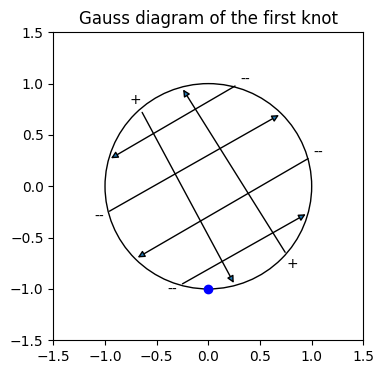

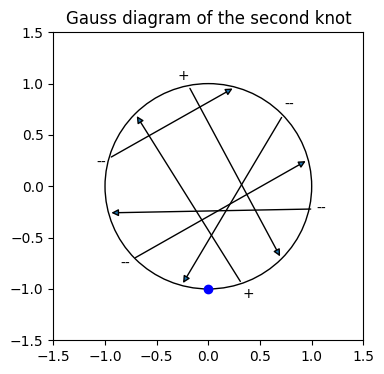

writhe =  -2 Whiteny index = 0
writhe =  -2 Whiteny index = 0


100%|██████████| 48/48 [00:10<00:00,  4.71it/s]


x_id_push_twist =  2*A**4*Z**5 + 17*A**4*Z**3 + 11*A**4*Z + A**4/Z + 2*A**2*Z**11 + 16*A**2*Z**9 + 27*A**2*Z**7 - 43*A**2*Z**5 - 107*A**2*Z**3 - 51*A**2*Z - 7*A**2/Z - 2*Z**15 - 21*Z**13 - 74*Z**11 - 83*Z**9 + 70*Z**7 + 265*Z**5 + 273*Z**3 + 125*Z + 18/Z + 2*Z**15/A**2 + 24*Z**13/A**2 + 103*Z**11/A**2 + 167*Z**9/A**2 - 26*Z**7/A**2 - 376*Z**5/A**2 - 398*Z**3/A**2 - 162*Z/A**2 - 21/(A**2*Z) - 2*Z**13/A**4 - 18*Z**11/A**4 - 54*Z**9/A**4 - 51*Z**7/A**4 + 48*Z**5/A**4 + 138*Z**3/A**4 + 73*Z/A**4 + 9/(A**4*Z) - 2*Z**11/A**6 - 13*Z**9/A**6 - 14*Z**7/A**6 + 48*Z**5/A**6 + 90*Z**3/A**6 + 31*Z/A**6 + 2/(A**6*Z) + 2*Z**9/A**8 + 10*Z**7/A**8 + 5*Z**5/A**8 - 28*Z**3/A**8 - 26*Z/A**8 - 2/(A**8*Z)
x_sig_push_twist =  5*A**4*Z**6 + 30*A**4*Z**4 + 25*A**4*Z**2 + 2*A**4 - 2*A**2*Z**10 - 20*A**2*Z**8 - 69*A**2*Z**6 - 98*A**2*Z**4 - 49*A**2*Z**2 - 4*A**2 + 2*Z**14 + 19*Z**12 + 58*Z**10 + 56*Z**8 - 7*Z**6 - 47*Z**4 - 49*Z**2 - 15 - 2*Z**14/A**2 - 22*Z**12/A**2 - 84*Z**10/A**2 - 110*Z**8/A**2 + 58*Z**6/A**

100%|██████████| 24/24 [00:21<00:00,  1.11it/s]


x_id_push_T2 =  (2*A**16*Z**6 + 17*A**16*Z**4 + 11*A**16*Z**2 + A**16 - 4*A**14*Z**10 - 39*A**14*Z**8 - 130*A**14*Z**6 - 144*A**14*Z**4 - 58*A**14*Z**2 - 7*A**14 + 5*A**12*Z**14 + 62*A**12*Z**12 + 294*A**12*Z**10 + 675*A**12*Z**8 + 805*A**12*Z**6 + 521*A**12*Z**4 + 167*A**12*Z**2 + 18*A**12 - 5*A**10*Z**16 - 66*A**10*Z**14 - 352*A**10*Z**12 - 1006*A**10*Z**10 - 1720*A**10*Z**8 - 1754*A**10*Z**6 - 986*A**10*Z**4 - 263*A**10*Z**2 - 21*A**10 + 3*A**8*Z**16 + 45*A**8*Z**14 + 272*A**8*Z**12 + 834*A**8*Z**10 + 1392*A**8*Z**8 + 1347*A**8*Z**6 + 745*A**8*Z**4 + 184*A**8*Z**2 + 9*A**8 + 4*A**6*Z**16 + 43*A**6*Z**14 + 167*A**6*Z**12 + 270*A**6*Z**10 + 130*A**6*Z**8 - 64*A**6*Z**6 - 59*A**6*Z**4 - 13*A**6*Z**2 + 2*A**6 - 4*A**4*Z**14 - 47*A**4*Z**12 - 199*A**4*Z**10 - 378*A**4*Z**8 - 333*A**4*Z**6 - 144*A**4*Z**4 - 35*A**4*Z**2 - 2*A**4 - 5*A**2*Z**12 - 30*A**2*Z**10 - 45*A**2*Z**8 + 8*A**2*Z**6 + 33*A**2*Z**4 + 8*A**2*Z**2 + 4*Z**10 + 23*Z**8 + 38*Z**6 + 16*Z**4)/(A**8*Z*(A**4 - A**2*Z**2 - Z**2

False

In [21]:
G0 = six_1
G1 = six_2
print(writhe(G0), whitney(G0))
print(writhe(G1), whitney(G1))

compare_vars_based_on_push_twist_and_tangle(G0, G1, numb_cores=4)


# right-handed trefoil and figure eight

1 1
1 1


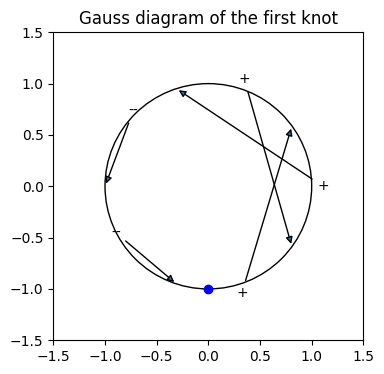

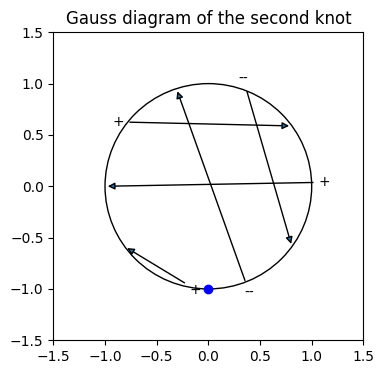

writhe =  1 Whiteny index = 1
writhe =  1 Whiteny index = 1


100%|██████████| 40/40 [00:09<00:00,  4.21it/s]


x_id_push_twist =  4*A**6*Z**3 + 10*A**6*Z + 2*A**6/Z - 5*A**4*Z**5 - 25*A**4*Z**3 - 29*A**4*Z - 6*A**4/Z + A**2*Z**7 + 10*A**2*Z**5 + 30*A**2*Z**3 + 25*A**2*Z + 9*A**2/Z - 7*Z**3 - 20*Z - 8/Z + 2*Z**7/A**2 + 11*Z**5/A**2 + 12*Z**3/A**2 + 3*Z/A**2 + 2/(A**2*Z) + Z**7/A**4 + 6*Z**5/A**4 + 14*Z**3/A**4 + 12*Z/A**4 + 2/(A**4*Z) - Z**5/A**6 - 6*Z**3/A**6 - 8*Z/A**6 - 1/(A**6*Z)
x_sig_push_twist =  (4*A**12*Z**4 + 14*A**12*Z**2 + 9*A**12 - 5*A**10*Z**6 - 31*A**10*Z**4 - 53*A**10*Z**2 - 20*A**10 + A**8*Z**8 + 11*A**8*Z**6 + 36*A**8*Z**4 + 35*A**8*Z**2 + 14*A**8 - 2*A**6*Z**4 - 3*A**6*Z**2 + A**6 + A**4*Z**2 - A**4 - A**2*Z**6 - 5*A**2*Z**4 - 12*A**2*Z**2 - 7*A**2 + Z**4 + 5*Z**2 + 4)/A**6
writhe =  1 Whiteny index = 1
writhe =  1 Whiteny index = 1


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


x_id_push_T2 =  (5*A**16*Z**4 + 12*A**16*Z**2 + 2*A**16 - 12*A**14*Z**6 - 46*A**14*Z**4 - 37*A**14*Z**2 - 6*A**14 + 8*A**12*Z**8 + 41*A**12*Z**6 + 60*A**12*Z**4 + 33*A**12*Z**2 + 9*A**12 - A**10*Z**10 - 4*A**10*Z**8 + 2*A**10*Z**6 + 8*A**10*Z**4 - 21*A**10*Z**2 - 8*A**10 - A**8*Z**10 - 9*A**8*Z**8 - 16*A**8*Z**6 + 8*A**8*Z**4 + A**8*Z**2 + 2*A**8 - 3*A**6*Z**10 - 18*A**6*Z**8 - 19*A**6*Z**6 + 16*A**6*Z**4 + 12*A**6*Z**2 + 2*A**6 - 3*A**4*Z**10 - 15*A**4*Z**8 - 14*A**4*Z**6 + 2*A**4*Z**4 - 2*A**4*Z**2 - A**4 - 4*A**2*Z**6 - 9*A**2*Z**4 - 7*A**2*Z**2 + 3*Z**6 + 8*Z**4 + 2*Z**2)/(A**6*Z*(A**4 - A**2*Z**2 - Z**2))
x_sig_push_T2 =  (5*A**16*Z**4 + 17*A**16*Z**2 + 10*A**16 - 12*A**14*Z**6 - 59*A**14*Z**4 - 77*A**14*Z**2 - 23*A**14 + 8*A**12*Z**8 + 51*A**12*Z**6 + 100*A**12*Z**4 + 62*A**12*Z**2 + 19*A**12 - A**10*Z**10 - 6*A**10*Z**8 - 3*A**10*Z**6 + 21*A**10*Z**4 - 6*A**10*Z**2 - 4*A**10 - A**8*Z**10 - 13*A**8*Z**8 - 44*A**8*Z**6 - 42*A**8*Z**4 - 23*A**8*Z**2 - 2*A**8 + A**6*Z**8 + 10*A**6*Z

False

In [23]:
G0 = trefoil_right
G1 = four_1
G0 = addcurl(G0, 3, 2)
G1 = addcurl(G1, 0, 1)

print(writhe(G0), whitney(G0))
print(writhe(G1), whitney(G1))

compare_vars_based_on_push_twist_and_tangle(G0, G1)

# nine_42

1 1
1 1


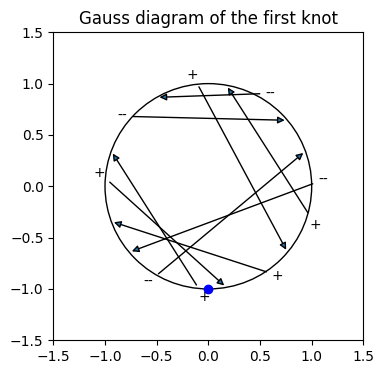

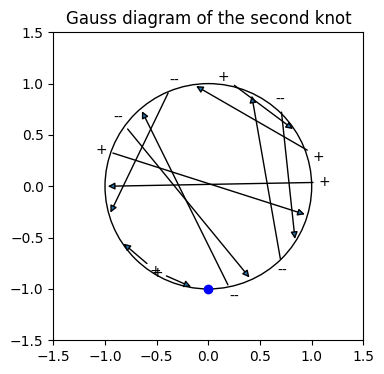

writhe =  1 Whiteny index = 1
writhe =  1 Whiteny index = 1


100%|██████████| 88/88 [00:39<00:00,  2.24it/s]


x_id_push_twist =  7*A**8*Z**7 + 44*A**8*Z**5 + 79*A**8*Z**3 + 37*A**8*Z - 7*A**6*Z**11 - 79*A**6*Z**9 - 327*A**6*Z**7 - 611*A**6*Z**5 - 506*A**6*Z**3 - 135*A**6*Z + 2*A**6/Z + 6*A**4*Z**13 + 80*A**4*Z**11 + 421*A**4*Z**9 + 1094*A**4*Z**7 + 1429*A**4*Z**5 + 840*A**4*Z**3 + 167*A**4*Z - 9*A**4/Z + A**2*Z**15 + 6*A**2*Z**13 - 15*A**2*Z**11 - 188*A**2*Z**9 - 517*A**2*Z**7 - 618*A**2*Z**5 - 327*A**2*Z**3 - 34*A**2*Z + 17*A**2/Z - Z**15 - 11*Z**13 - 49*Z**11 - 134*Z**9 - 291*Z**7 - 431*Z**5 - 324*Z**3 - 118*Z - 17/Z + 2*Z**11/A**2 + 26*Z**9/A**2 + 131*Z**7/A**2 + 306*Z**5/A**2 + 325*Z**3/A**2 + 116*Z/A**2 + 9/(A**2*Z) - Z**9/A**4 - 11*Z**7/A**4 - 41*Z**5/A**4 - 62*Z**3/A**4 - 36*Z/A**4 - 2/(A**4*Z)
x_sig_push_twist =  7*A**8*Z**8 + 51*A**8*Z**6 + 118*A**8*Z**4 + 91*A**8*Z**2 + 10*A**8 - 7*A**6*Z**12 - 86*A**6*Z**10 - 403*A**6*Z**8 - 901*A**6*Z**6 - 972*A**6*Z**4 - 426*A**6*Z**2 - 51*A**6 + 6*A**4*Z**14 + 88*A**4*Z**12 + 517*A**4*Z**10 + 1542*A**4*Z**8 + 2453*A**4*Z**6 + 2031*A**4*Z**4 + 817

100%|██████████| 44/44 [01:42<00:00,  2.32s/it]


x_id_push_T2 =  (8*A**16*Z**8 + 50*A**16*Z**6 + 88*A**16*Z**4 + 39*A**16*Z**2 - 8*A**14*Z**12 - 99*A**14*Z**10 - 429*A**14*Z**8 - 795*A**14*Z**6 - 613*A**14*Z**4 - 149*A**14*Z**2 + 2*A**14 + 16*A**12*Z**14 + 196*A**12*Z**12 + 914*A**12*Z**10 + 2044*A**12*Z**8 + 2271*A**12*Z**6 + 1150*A**12*Z**4 + 207*A**12*Z**2 - 9*A**12 - 7*A**10*Z**16 - 95*A**10*Z**14 - 514*A**10*Z**12 - 1407*A**10*Z**10 - 2054*A**10*Z**8 - 1600*A**10*Z**6 - 687*A**10*Z**4 - 97*A**10*Z**2 + 17*A**10 - A**8*Z**18 - 12*A**8*Z**16 - 64*A**8*Z**14 - 223*A**8*Z**12 - 543*A**8*Z**10 - 770*A**8*Z**8 - 512*A**8*Z**6 - 177*A**8*Z**4 - 56*A**8*Z**2 - 17*A**8 + 7*A**6*Z**16 + 87*A**6*Z**14 + 420*A**6*Z**12 + 1002*A**6*Z**10 + 1258*A**6*Z**8 + 852*A**6*Z**6 + 343*A**6*Z**4 + 74*A**6*Z**2 + 9*A**6 + A**4*Z**18 + 10*A**4*Z**16 + 36*A**4*Z**14 + 64*A**4*Z**12 + 83*A**4*Z**10 + 67*A**4*Z**8 - 27*A**4*Z**6 - 20*A**4*Z**4 - 14*A**4*Z**2 - 2*A**4 - A**2*Z**14 - 15*A**2*Z**12 - 87*A**2*Z**10 - 230*A**2*Z**8 - 269*A**2*Z**6 - 92*A**2*Z**

False

In [24]:
G0 = nine_42
G1 = mirror(G0)
G1 = addcurl(G1, 0, 1)
G1 = addcurl(G1, 1, 1)
print(writhe(G0), whitney(G0))
print(writhe(G1), whitney(G1))

# pd_temp = Gauss_matrix_to_PD(G0)
# homfly_pd(pd_temp)

compare_vars_based_on_push_twist_and_tangle(G0, G1)

# trefoil chirality

In [152]:
G0 = trefoil_left
G0 = addcurl(G0, 0, 2)
G1 = mirror(G0)
G1 = addcurl(G1, 2, 1)
G1 = addcurl(G1, 3, 1)
print(writhe(G0), whitney(G0))
print(writhe(G1), whitney(G1))

# pd_temp = Gauss_matrix_to_PD(G0)
# homfly_pd(pd_temp)

compare_vars_based_on_push_twist_and_tangle(G0, G1)

-1 1
-1 1
writhe, whitney
-1 1
-1 1


100%|██████████| 28/28 [00:06<00:00,  4.21it/s]


x_id =  (-7*A**16*Z**2 - 4*A**16 + 2*A**14*Z**6 + 9*A**14*Z**4 + 25*A**14*Z**2 + 16*A**14 + A**12*Z**8 + 2*A**12*Z**6 - 17*A**12*Z**4 - 39*A**12*Z**2 - 20*A**12 + 2*A**10*Z**6 + 12*A**10*Z**4 + 18*A**10*Z**2 + 8*A**10 - A**6*Z**8 - 7*A**6*Z**6 - 16*A**6*Z**4 - 15*A**6*Z**2 - 4*A**6 - 4*A**4*Z**12 - 34*A**4*Z**10 - 95*A**4*Z**8 - 88*A**4*Z**6 + 17*A**4*Z**4 + 47*A**4*Z**2 + 10*A**4 + A**2*Z**12 + 9*A**2*Z**10 + 21*A**2*Z**8 - 10*A**2*Z**6 - 72*A**2*Z**4 - 57*A**2*Z**2 - 8*A**2 - Z**10 - 3*Z**8 + 10*Z**6 + 36*Z**4 + 24*Z**2 + 2)/(A**10*Z)
x_sig =  (-7*A**16*Z**2 - 11*A**16 + 2*A**14*Z**6 + 14*A**14*Z**4 + 40*A**14*Z**2 + 28*A**14 - 2*A**12*Z**8 - 14*A**12*Z**6 - 32*A**12*Z**4 - 32*A**12*Z**2 - 19*A**12 + 2*A**10 + A**6*Z**6 + 6*A**6*Z**4 + 10*A**6*Z**2 + 5*A**6 + 4*A**4*Z**10 + 30*A**4*Z**8 + 69*A**4*Z**6 + 42*A**4*Z**4 - 29*A**4*Z**2 - 21*A**4 - A**2*Z**10 - 8*A**2*Z**8 - 14*A**2*Z**6 + 18*A**2*Z**4 + 51*A**2*Z**2 + 25*A**2 + Z**8 + 2*Z**6 - 11*Z**4 - 25*Z**2 - 9)/A**10
writhe, whitney


100%|██████████| 28/28 [00:05<00:00,  5.50it/s]


delta_sig =  (A**12*(6*A**6*Z**2 + 10*A**6 - 2*A**4*Z**6 - 18*A**4*Z**4 - 48*A**4*Z**2 - 27*A**4 + 4*A**2*Z**8 + 27*A**2*Z**6 + 64*A**2*Z**4 + 63*A**2*Z**2 + 27*A**2 - 2*Z**10 - 13*Z**8 - 29*Z**6 - 43*Z**4 - 47*Z**2 - 18) + 2*A**10*(Z**6 + 6*Z**4 + 10*Z**2 + 4) - A**8*Z**6 - 6*A**8*Z**4 - 10*A**8*Z**2 - 5*A**8 - 3*A**6*Z**10 - 21*A**6*Z**8 - 41*A**6*Z**6 - 7*A**6*Z**4 + 43*A**6*Z**2 + 21*A**6 - 3*A**4*Z**10 - 21*A**4*Z**8 - 52*A**4*Z**6 - 72*A**4*Z**4 - 60*A**4*Z**2 - 23*A**4 - A**2*Z**8 - 6*A**2*Z**6 - 6*A**2*Z**4 + 8*A**2*Z**2 + 6*A**2 + 4*Z**6 + 16*Z**4 + 13*Z**2 + 1)/A**11
delta_id =  (A**12*Z**2*(6*A**6 - 2*A**4*Z**4 - 14*A**4*Z**2 - 33*A**4 + 2*A**2*Z**6 + 16*A**2*Z**4 + 56*A**2*Z**2 + 62*A**2 - 2*Z**8 - 13*Z**6 - 28*Z**4 - 35*Z**2 - 32) + 4*A**12*(A**6 - 4*A**4 + 5*A**2 - 2) + 2*A**10*Z**2 + A**8*Z**8 + 7*A**8*Z**6 + 16*A**8*Z**4 + 15*A**8*Z**2 + 4*A**8 + 3*A**6*Z**12 + 24*A**6*Z**10 + 59*A**6*Z**8 + 31*A**6*Z**6 - 56*A**6*Z**4 - 55*A**6*Z**2 - 10*A**6 + 3*A**4*Z**12 + 24*A**4*Z

False

# 10_71

In [ ]:
G0 = ten_71
G0 = addcurl(G0, 1, 1)
G1 = mirror(ten_71)
G1 = addcurl(G1, 1, 1)
print(writhe(G0), whitney(G0))
print(writhe(G1), whitney(G1))

compare_vars_based_on_push_twist_and_tangle(G0, G1)